In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.metrics
import time
import seaborn as sns
import pandas as pd
import random
import math
from math import log, sin, pi
from IPython.display import display
import collections

import sklearn
print ('scikit-learn version: ', sklearn.__version__)
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics.cluster import normalized_mutual_info_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras import initializers, regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

ID = 2029013

import sys
sys.path.append("/content/drive/MyDrive/LOCP(B)/")
from RLclustering import *

scikit-learn version:  0.22.2.post1


In [3]:
# threshold distance counter (chi function in the article)
def thr_chi(d,dc): 
  return d < dc

# gaussian distance counter (chi function in the article)
def gau_chi(d,dc):
  return np.exp(-0.5*(d/dc)**2)

# calculating discrete derivates with 4 points (see wikipedia)
def finite_derivative(v):
    
    L = len(v)
    d1 = np.delete(v, [L-4, L-3, L-2, L-1])              #f[x+2]
    d2 = np.delete(v, [0,L-3,L-2,L-1])                   #f[x+1]
    d3 = np.delete(v, [0, 1, 2, L-1])                    #f[x-1]
    d4 = np.delete(v, [0,1,2,3])                         #f[x-2]
    
    return (-d1+8*d2-8*d3+d4)/12

# smooth average a point and N point before and after it
def smooth(v,N):
    v = np.asarray(v)
    L = len(v)
    sv = np.zeros(L)
    
    for i in range(N):
        sv[i] = np.mean(v[:i+N])
    for i in range(N,L-N):
        sv[i] = np.mean(v[i-N:i+N])
    for i in range(L-N,L):
        sv[i] = np.mean(v[i-N:])  
          
    return sv

# Data load and manipulation

In [ ]:
days = ("sunday", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday") 

# indoor sensor 1
df_in = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/Ringebu_DL1_year.csv" ,names=['n','Data', 'RH', 'T'],header=0)
df_mr = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/mixing_ratio_DL1_year.csv" ,names=['n','Data', 'MR'],header=0)
# indoor sensor 2
df_in2 = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/Ringebu_DL2_year.csv" ,names=['n','Data', 'RH', 'T'],header=0)
df_mr2 = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/mixing_ratio_DL2_year.csv" ,names=['n','Data', 'MR'],header=0)
# outdoor
df_out = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/Ringebu_DL3_year.csv" ,names=['n','Data', 'RH', 'T'],header=0)
df_mr3 = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/mixing_ratio_DL3_year.csv" ,names=['n','Data', 'MR'],header=0)

metadata_df = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Data_Stave_Churches/Ringebu/Metadata_Ringebu.csv" ,names=['n',"Start","Duration","End","Event","People","Start Heating"],header=0)

# converting string do datetime
df_in['Data'] = pd.to_datetime(df_in['Data'], format='%Y-%m-%d %H:%M:%S')
df_in2['Data'] = pd.to_datetime(df_in2['Data'], format='%Y-%m-%d %H:%M:%S')
df_out['Data'] = pd.to_datetime(df_out['Data'], format='%Y-%m-%d %H:%M:%S')
metadata_df['Start'] = pd.to_datetime(metadata_df['Start'], format='%m/%d/%Y %H:%M')

# creating new colums, useful for analysis
#df_in['Day'] = [ days[ df_in['Data'][i].weekday() ] for i in range(len(df_in['Data']))]
df_in['Day_number'] = [  df_in['Data'][i].timetuple().tm_yday  for i in range(len(df_in['Data']))]
df_in['MR'] = df_mr['MR']

#df_in2['Day'] = [ days[ df_in['Data'][i].weekday() ] for i in range(len(df_in['Data']))]
df_in2['Day_number'] = [  df_in2['Data'][i].timetuple().tm_yday  for i in range(len(df_in2['Data']))]
df_in2['MR'] = df_mr2['MR']

#df_out['Day'] = [ days[ df_out['Data'][i].weekday() ] for i in range(len(df_out['Data']))]
df_out['Day_number'] = [  df_out['Data'][i].timetuple().tm_yday  for i in range(len(df_out['Data']))]
df_out['MR'] = df_mr3['MR']

metadata_df['Day_number'] = [metadata_df['Start'][i].timetuple().tm_yday  for i in range(len(metadata_df['Start']))]

In [ ]:
d = np.sum( np.isnan(df_out['MR']) )
print(d, "NaN value in MR column")
df_out = df_out.fillna(2.11)          # the NaN value is the last element of the column. I set it similar to previous one
df_in = df_in.fillna(2.188)           # the NaN value is the last element of the column. I set it similar to previous one
df_in2 =df_in2.fillna(2.19)           # the NaN value is the last element of the column. I set it similar to previous one

df_in = df_in.sort_values( by=["Day_number","n"] )
df_in2 = df_in2.sort_values( by=["Day_number","n"] )
df_out = df_out.sort_values( by=["Day_number","n"] )
df_in2

In [ ]:
# there can be only one day number 89 (see df_in printed before)
# il problema e' che il 2020 e' un anno bisestile 
din = df_in[df_in["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
dout = df_out[df_out["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
din2 = df_in[df_in2["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]

x = np.unique(din["Day_number"])
N = len(x)

# Possibili variabili da clusterizzare 
std_Tin = np.zeros(N)        # dev std di Tin 
std_Tout = np.zeros(N)       # dev std di Tout 
std_RHin = np.zeros(N)       # dev std di RHin
std_MRin = np.zeros(N)       # dev std di MRin 
std_MRin2 = np.zeros(N)       # dev std di MRin 
std_MRout = np.zeros(N)       # dev std di MRout
std_RHout = np.zeros(N)       # dev std di RHout
std_diff_T = np.zeros(N)     # dev std di Tin-Tout
std_diff_RH = np.zeros(N)    # dev std di RHin-RHout
std_diff_MR = np.zeros(N)    # dev std di MRin-MRout
mean_Tout = np.zeros(N)       #mean di Tout

std_der_Tin = np.zeros(N)    # dev std of T derivative
std_der_Tin2 = np.zeros(N)    # dev std of T derivative sensore 2
std_der_MRin = np.zeros(N)    # dev std of MR derivative
std_der_MRin2 = np.zeros(N)    # dev std of MR derivative sensore 2
std_der_RHin = np.zeros(N)    # dev std of RH derivative
std_der_Tout = np.zeros(N)    # dev std of T derivative
std_der_MRout = np.zeros(N)    # dev std of MR derivative
std_der_RHout = np.zeros(N)    # dev std of RH derivative

std_der_diff_T = np.zeros(N)
std_der_diff_RH = np.zeros(N)
std_der_diff_MR = np.zeros(N)
std_der_MR = np.zeros(N)     # dev std of MR derivative

std_sumdiff_der_MR = np.zeros(N)


for i in range(N):
    data_in = din[din["Day_number"]==i+1]
    data_in2 = din2[din2["Day_number"]==i+1]
    data_out = dout[dout["Day_number"]==i+1]

    std_der_Tin[i] = np.std( finite_derivative( np.asarray(data_in["T"]) ))
    std_der_Tin2[i] = np.std( finite_derivative( np.asarray(data_in2["T"]) )) #sensore 2 
    std_der_MRin2[i] = np.std( finite_derivative( np.asarray(data_in2["MR"]) )) #sensore 2 
    std_der_MRin[i] = np.std( finite_derivative( np.asarray(data_in["MR"]) ))
    std_der_RHin[i] = np.std( finite_derivative( np.asarray(data_in["RH"]) ))
    std_der_Tout[i] = np.std( finite_derivative( np.asarray(data_out["T"]) )) 
    std_der_MRout[i] = np.std( finite_derivative( np.asarray(data_out["MR"]) ))
    std_der_RHout[i] = np.std( finite_derivative( np.asarray(data_out["RH"]) ))  
    std_der_MR[i] = np.std( abs(finite_derivative( np.asarray(data_in["MR"]) )) )
    
    mean_Tout[i] = np.mean(np.asarray(data_out["T"]))
    std_Tin[i] = np.std( np.asarray(data_in["T"]) )
    std_MRin[i] = np.std( np.asarray(data_in["MR"]) )
    std_MRin2[i] = np.std( np.asarray(data_in2["MR"]) )
    std_MRout[i] = np.std( np.asarray(data_out["MR"]) )
    std_Tout[i] = np.std( np.asarray(data_out["T"]) )
    std_RHin[i] = np.std( np.asarray(data_in["RH"]) )
    std_RHout[i] = np.std( np.asarray(data_out["RH"]) )
    std_diff_T[i] = np.std( data_in["T"] - data_out["T"] )
    std_diff_RH[i] = np.std( data_in["RH"] - data_out["RH"] )
    std_diff_MR[i] = np.std( finite_derivative( np.asarray( data_in["MR"] - data_out["MR"] )))
    
    std_der_diff_T[i] = np.std( finite_derivative( np.asarray( data_in["T"]-data_out["T"] ) )) 
    std_der_diff_RH[i] = np.std( finite_derivative( np.asarray( data_in["RH"]-data_out["RH"] ) )) 
    std_der_diff_MR[i] = np.std( finite_derivative( np.asarray( data_in["MR"]-data_out["MR"] ) ))
    std_sumdiff_der_MR[i] = np.std(abs(finite_derivative(np.asarray(data_in["MR"])) * finite_derivative(np.asarray(data_in2["MR"]))) - abs(finite_derivative(np.asarray(data_out["MR"])))) 

      
#unuseful data
data_season = np.vstack((
    std_Tin/np.mean(std_Tin),        # dev std di Tin 
    std_Tout/np.mean(std_Tout),       # dev std di Tout 
    std_RHin/np.mean(std_RHin),       # dev std di RHin
    std_MRin/np.mean(std_MRin),      # dev std di MRin 
    std_MRout/np.mean(std_MRout),       # dev std di MRout
    std_RHout/np.mean(std_RHout),       # dev std di RHout
    std_diff_T/np.mean(std_diff_T),    # dev std di Tin-Tout
    std_diff_RH/np.mean(std_diff_RH),   # dev std di RHin-RHout
    std_diff_MR/np.mean(std_diff_MR),   # dev std di MRin-MRout

    std_der_Tin/np.mean(std_der_Tin),    # dev std of T derivative
    std_der_Tin2/np.mean(std_der_Tin2),    # dev std of T derivative sensore 2
    std_der_MRin/np.mean(std_der_MRin),     # dev std of MR derivative
    std_der_MRin2/np.mean(std_der_MRin2),     # dev std of MR derivative sensore 2
    std_der_RHin/np.mean(std_der_RHin),     # dev std of RH derivative
    std_der_Tout/np.mean(std_der_Tout),    # dev std of T derivative
    std_der_MRout/np.mean(std_der_MRout),     # dev std of MR derivative
    std_der_RHout/np.mean(std_der_RHout),    # dev std of RH derivative

    std_der_diff_T/np.mean(std_der_diff_T), 
    std_der_diff_RH/np.mean(std_der_diff_RH), 
    std_der_diff_MR /np.mean(std_der_diff_MR), 
    std_der_MR/np.mean(std_der_MR)     # dev std of MR derivative
    
    )).T

#australia
data_der = np.vstack((std_der_Tin/np.mean(std_der_Tin),    # Dev std del valore assuluto della derivata di Tin
                      #std_diff_T/np.mean(std_diff_T),
                      std_diff_MR/np.mean(std_diff_MR),
                      std_RHin/np.mean(std_RHin),          # Dev std del valore assuluto della derivata di RHin
                      std_MRin/np.mean(std_MRin))).T       # Dev std del valore assuluto della derivata di MR

## Visualization cluster

In [ ]:
event_labels = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1            # day 1 is element 0
event_labels[event_days]=1

In [ ]:
df_data_season = pd.DataFrame(data_season, 
                              columns=['std_Tin', 'std_Tout', 'std_RHin', 'std_MRin', 'std_MRout', 'std_RHout', 'std_diff_T', 'std_diff_RH', 'std_diff_MR', 'std_der_Tin', 'std_der_Tin2',
                                       'std_der_MRin', 'std_der_MRin2', 'std_der_RHin', 'std_der_Tout', 'std_der_MRout', 'std_der_RHout', 'std_der_diff_T', 'std_der_diff_RH', 'std_der_diff_MR', 'std_der_MR'])
df_data_season['event'] = event_labels

#df_data_season

In [ ]:
#sns.pairplot(df_data_season, hue='event')

In [ ]:
#sns.pairplot(df_in)

In [ ]:
#sns.pairplot(df_in2)

In [ ]:
#sns.pairplot(df_out)

# The outside world

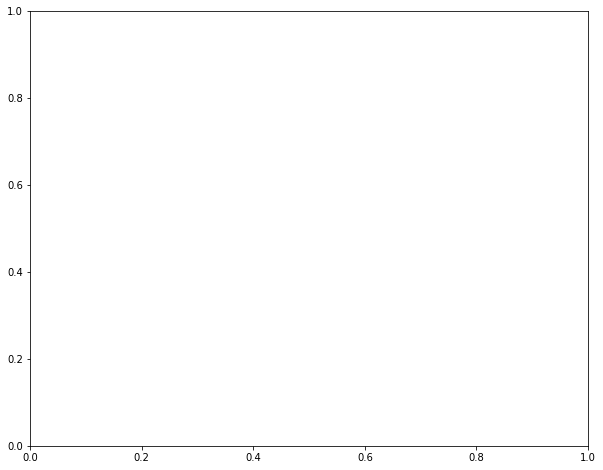

In [ ]:
cmap = plt.cm.jet
cmaplist = [plt.cm.jet(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
fig, ax = plt.subplots(figsize=(10, 8))


#scat = ax.scatter(data_season[:,0],data_season[:,1],c=month_labels,label=month_labels,cmap=cmap)
#ax.set_title("Month labels", fontsize=14)
#ax.legend(*scat.legend_elements(),  loc='best', fontsize=14);

# ==================== Giochino con i picchi =======================

In [ ]:
# funzione fondamentalissima che nota la data ci da il numero del giorno
def day_number(data):
    return pd.to_datetime(data, format='%Y-%m-%d %H:%M:%S').timetuple().tm_yday 
    
print(day_number("2019-03-10 00:00:05"))

69


In [ ]:
# liste dei """true label"""
print(np.unique(metadata_df['Day_number']))

[  3  21  26  31  52  54  92  95 102 104 106 108 111 114 116 118 130 132
 135 143 146 152 158 159 160 161 167 172 177 179 181 186 187 188 194 195
 198 200 203 209 215 221 226 230 244 249 256 263 265 279 284 295 300 305
 307 321 324 333 335 344 353 355 358 359 363]


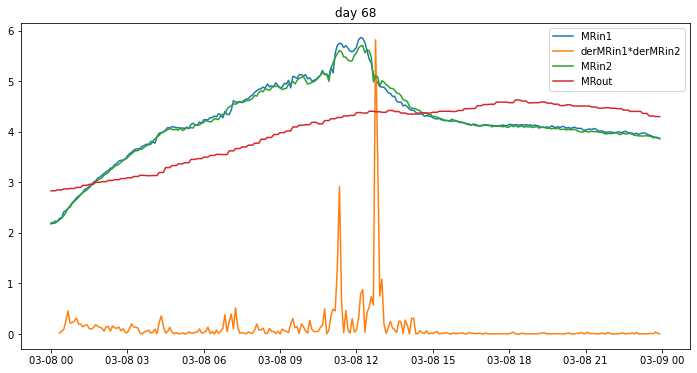

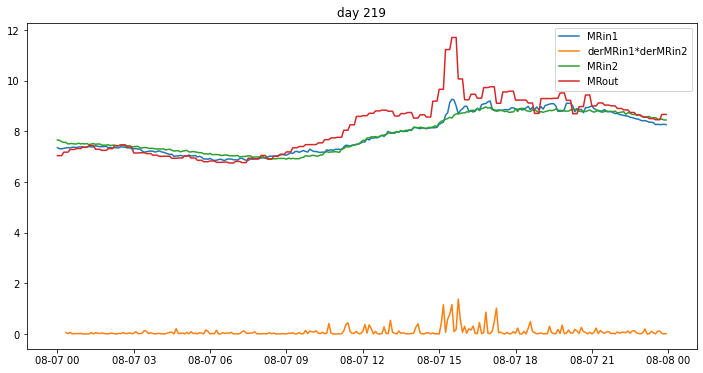

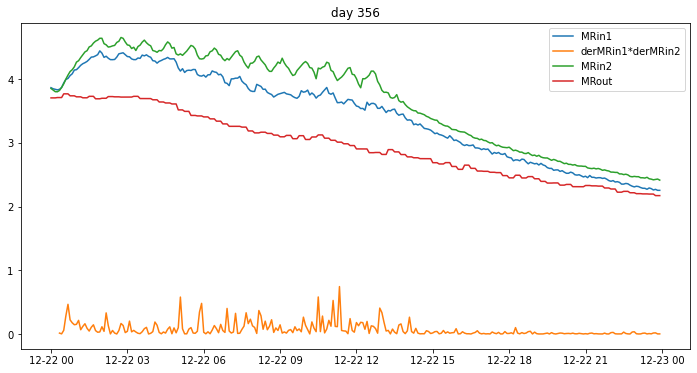

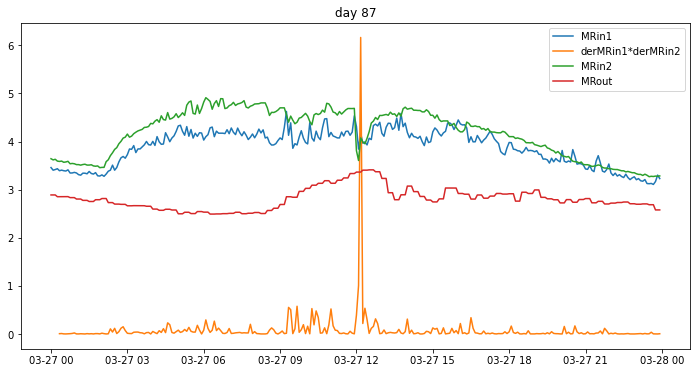

In [ ]:
def smooth(v,N):
    v = np.asarray(v)
    L = len(v)
    sv = np.zeros(L)
    
    sv[:N] = v[0]
    sv[L-1-N:L] = v[L-1]
    for i in range(N,L-N):
        sv[i] = np.mean(v[i-N:i+N])
        
    return sv

def picchi_plot(N_day,mult_factor=100):
  din = df_in[df_in["Day_number"] == N_day]
  din2 = df_in2[df_in2["Day_number"] == N_day]
  dout = df_out[df_out["Day_number"] == N_day]
  z = np.asarray(din["Data"])
  x = np.delete(z, [0,1,2,3])

  ax,fil = plt.subplots(figsize=(12,6))
  plt.plot(din["Data"],din["MR"], label="MRin1")
  # il fattore mult_factor (100 di default) e' messo per visualizzare meglio il tutto
  y = mult_factor*abs( finite_derivative( np.asarray(din["MR"]) ) *finite_derivative( np.asarray(din2["MR"]) ) ) 
  plt.plot(x, y, label="derMRin1*derMRin2")

  plt.plot(din["Data"],din2["MR"], label="MRin2")
  plt.plot(din["Data"],dout["MR"], label="MRout")
  plt.title( "day " + str(N_day))
  plt.legend();
  plt.show()

picchi_plot(68)
picchi_plot(219)
picchi_plot(356)
picchi_plot(87,mult_factor=20)

MRout = smooth(np.asarray(dout["MR"]),4)
yout = abs(finite_derivative( MRout ) )

In [ ]:
# cerchiamo giorni sospetti

# there can be only one day number 89 (see df_in printed before)
# il problema e' che il 2020 e' un anno bisestile ahah
din = df_in[df_in["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
din2 = df_in2[df_in2["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
dout = df_out[df_out["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]

N = 365

picchi_integral = np.zeros(N)
picchi_std = np.zeros(N)
picchi_MRout = np.zeros(N)
derder = []
mrmr = []
picchi_MR = np.zeros(N)


for i in range(N):
  data_in = din[din["Day_number"]==i+1]
  data_in2 = din2[din2["Day_number"]==i+1]
  data_out = dout[dout["Day_number"]==i+1]
    
  t = abs( finite_derivative( np.asarray(data_in["MR"]) )* finite_derivative( np.asarray(data_in2["MR"]) ) )
  derder.append(t/100)
  mrmr.append(abs( finite_derivative( np.asarray(data_out["MR"]))))
  picchi_std[i] = np.std(t)
  picchi_integral[i] = np.sum(t)
  picchi_MRout[i] = np.sum(yout[i])
  picchi_MR[i] = np.sum(t)/(np.sum(yout[i]))

predicted1 = np.array(np.where(picchi_integral>18)) + 1
print("Giorni sospetti")
print(predicted1)

predicted2 = np.asarray(np.where(picchi_integral>30)) + 1
print("Giorni mooolto sospetti")
print(predicted2)

print("True label")
true_label = np.unique(metadata_df['Day_number'])
print(true_label)

# Guardando i giorni sospetti e molto sospetti si trovano anche giorni di pioggia (tipo alcuni di quelli dal 201 al 211)

# Fake sgamati: 31, 63, 68, forse 87 , ecc ...

Giorni sospetti
[]
Giorni mooolto sospetti
[]
True label
[  3  21  26  31  52  54  92  95 102 104 106 108 111 114 116 118 130 132
 135 143 146 152 158 159 160 161 167 172 177 179 181 186 187 188 194 195
 198 200 203 209 215 221 226 230 244 249 256 263 265 279 284 295 300 305
 307 321 324 333 335 344 353 355 358 359 363]


# derMR and T clustering

In [ ]:
din['Hour'] = din['Data'].dt.hour
din2['Hour'] = din2['Data'].dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
N = 365
H = 24

peaks_daily = np.zeros((N, 8))

for i in range(N):
  data_in = din[din["Day_number"]==i+1]
  data_in2 = din2[din2["Day_number"]==i+1]
  for j in range(H):
      data_in_in = data_in[data_in["Hour"]==j]
      data_in2_in2 = data_in2[data_in2["Hour"]==j]
    
  t = 100*abs( finite_derivative( np.asarray(data_in_in["MR"]) )* finite_derivative( np.asarray(data_in2_in2["MR"]) ) )
  peaks_daily[i] = np.asarray(t)

## picchi sigmoid

0.06272952326600745


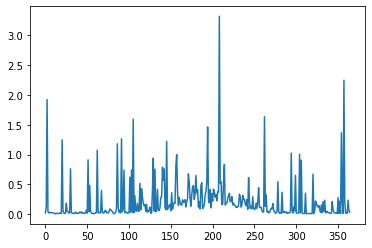

In [ ]:
peaks_daily = peaks_daily/np.mean(peaks_daily)
#picchi_integral = picchi_integral/np.sum(picchi_integral)
print(np.mean(picchi_integral)/max(picchi_integral))

plt.plot(picchi_integral)

In [ ]:
#thr_peaks = 4*np.median(abs(picchi_integral)/0.6745)
thr_peaks = np.std(abs(picchi_integral))

#sigmoid filter
picchi_sigmoid = 1./(1.+np.exp(-2*picchi_integral + 2*thr_peaks))

predicted1 = np.array(np.where(picchi_sigmoid>0.5)) + 1
print("Giorni sospetti")
print(predicted1)

Giorni sospetti
[[  3  21  31  52  54  63  68  87  92  95 102 104 106 114 116 129 130 132
  135 141 142 143 146 152 157 158 159 172 173 177 178 181 182 183 187 188
  193 194 195 198 202 203 207 208 209 210 211 214 215 244 256 263 279 284
  295 300 305 307 312 321 355 358]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  """


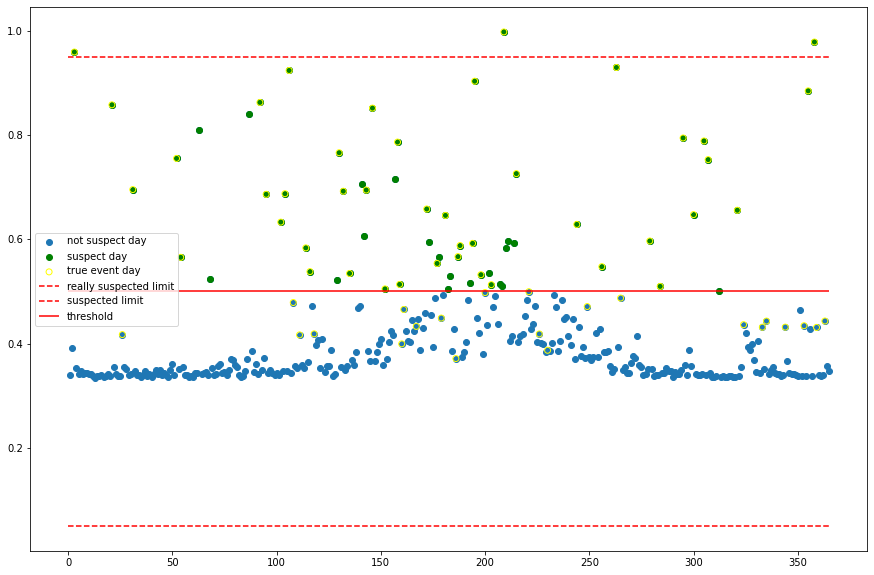

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(np.unique(df_in['Day_number']), picchi_sigmoid, label='not suspect day')
ax.scatter(predicted1, picchi_sigmoid[predicted1 - 1], color='green', label='suspect day') 
ax.scatter(true_label, picchi_sigmoid[true_label - 1], color='', edgecolors='yellow', label='true event day')
ax.hlines(0.95, 0, 365, color='red', linestyles='--', label='really suspected limit')
ax.hlines(0.05, 0, 365, color='red', linestyles='--', label='suspected limit')
ax.hlines(0.5, 0, 365, color='red', label='threshold')
ax.legend(loc='center left');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


1.0
precision: 0.1780821917808219
recall: 1.0


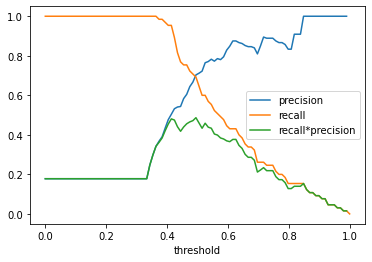

In [ ]:
# FINDING TRUE LABELS    1 = EVENT WITH VISITORS   0 = NO EVENT, NO VISITORS

event_labels = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1            # day 1 is element 0
event_labels[event_days]=1

precision = np.zeros(100)
recall = np.zeros(100)

a = 0
b = 1

x = np.linspace(a,b, 100)

pr = np.zeros(365)

for i in range(100):
    predict = np.asarray(np.where( picchi_sigmoid > x[i])) 
    pr = np.zeros(365)
    
    pr[predict]=1

    predicted = np.sum(pr)
    correct = np.sum(event_labels*pr)
    total = len(event_days)
    
    precision[i] = correct/predicted
    recall[i] = correct/total

plt.plot(x,precision,label="precision")
plt.plot(x,recall,label="recall")
plt.plot(x,recall*precision,label="recall*precision")
plt.legend()
plt.xlabel("threshold")

predict = np.asarray(np.where( picchi_sigmoid > 0.2)) 

pr = np.zeros(365)

pr[predict]=1

predicted = np.sum(pr)
correct = np.sum(event_labels*pr)
total = len(event_days)

print(x[np.argmax(recall*precision)])
print("precision:" ,correct/predicted)
print("recall:", correct/total)

In [ ]:
 compact = False
 
 if compact: 
  #trasformo gli eventi internedi in 0.5
  for i in range(len(picchi_sigmoid)):
    if picchi_sigmoid[i] > 0.05 and picchi_sigmoid[i] < 1.0 : picchi_sigmoid[i] = 0.5

  fig, ax = plt.subplots(figsize=(15, 10))

  ax.scatter(np.unique(df_in['Day_number']), picchi_sigmoid, label='not suspect day')
  ax.scatter(predicted1, picchi_sigmoid[predicted1 - 1], color='green', label='suspect day') 
  ax.scatter(true_label, picchi_sigmoid[true_label - 1], color='', edgecolors='yellow', label='true event day')
  ax.hlines(0.95, 0, 365, color='red', linestyles='--', label='really suspected limit')
  ax.hlines(0.05, 0, 365, color='red', linestyles='--', label='suspected limit')
  ax.hlines(0.5, 0, 365, color='red', label='threshold')
  ax.legend(loc='center left');

## picchi MR out

0.16613600881748514


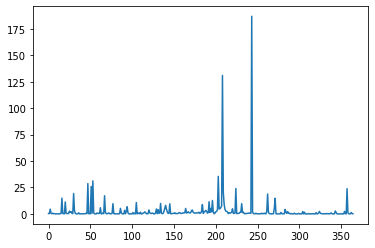

In [ ]:
print(np.mean(picchi_MRout)/max(picchi_MRout))
picchi_MR = 1000*picchi_MR/np.sum(picchi_MR)
plt.plot((picchi_MR))

In [ ]:
#thr_peaks = 4*np.median(abs(picchi_integral)/0.6745)
thr_peaks = np.std(abs(picchi_MR))
print(thr_peaks)

#sigmoid filter
MR_sigmoid = 1./(1.+np.exp(-5*picchi_MR + thr_peaks))

predicted1 = np.array(np.where(MR_sigmoid>0.5)) + 1
print("Giorni sospetti")
print(predicted1)

12.60950811801913
Giorni sospetti
[[  3  17  21  26  31  32  48  52  54  63  68  78  87  92  94  95 106 121
  130 132 135 140 141 142 146 165 172 173 185 189 193 195 197 203 204 205
  206 207 208 209 210 211 212 213 221 225 232 244 262 263 271 272 284 344
  358]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  """


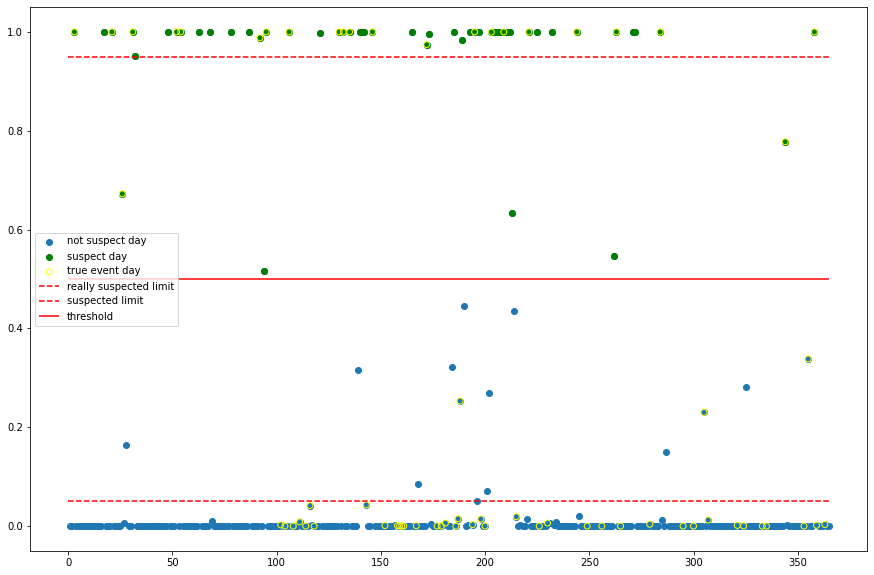

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(np.unique(df_in['Day_number']), MR_sigmoid, label='not suspect day')
ax.scatter(predicted1, MR_sigmoid[predicted1 - 1], color='green', label='suspect day') 
ax.scatter(true_label, MR_sigmoid[true_label - 1], color='', edgecolors='yellow', label='true event day')
ax.hlines(0.95, 0, 365, color='red', linestyles='--', label='really suspected limit')
ax.hlines(0.05, 0, 365, color='red', linestyles='--', label='suspected limit')
ax.hlines(0.5, 0, 365, color='red', label='threshold')
ax.legend(loc='center left');

0.36363636363636365
precision: 0.3352601156069364
recall: 0.8923076923076924


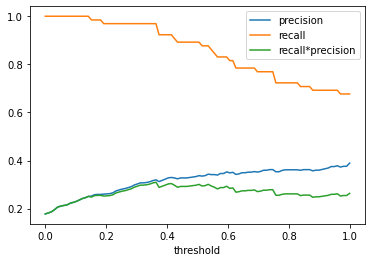

In [ ]:
# FINDING TRUE LABELS    1 = EVENT WITH VISITORS   0 = NO EVENT, NO VISITORS

event_labels = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1            # day 1 is element 0
event_labels[event_days]=1

precision = np.zeros(100)
recall = np.zeros(100)

a = 0
b = 1

x = np.linspace(a,b, 100)

pr = np.zeros(365)

for i in range(100):
    predict = np.asarray(np.where( picchi_MR > x[i])) 
    pr = np.zeros(365)
    
    pr[predict]=1

    predicted = np.sum(pr)
    correct = np.sum(event_labels*pr)
    total = len(event_days)
    
    precision[i] = correct/predicted
    recall[i] = correct/total

plt.plot(x,precision,label="precision")
plt.plot(x,recall,label="recall")
plt.plot(x,recall*precision,label="recall*precision")
plt.legend()
plt.xlabel("threshold")

predict = np.asarray(np.where( picchi_MR > 0.5)) 

pr = np.zeros(365)

pr[predict]=1

predicted = np.sum(pr)
correct = np.sum(event_labels*pr)
total = len(event_days)

print(x[np.argmax(recall*precision)])
print("precision:" ,correct/predicted)
print("recall:", correct/total)

## cluster picchi

In [ ]:
len(mrmr)

365

In [ ]:
data_derMR = np.vstack((
    #picchi_integral/np.mean(picchi_integral),
    #std_der_MRout/np.mean(std_der_MRout),
    #std_der_Tin/np.mean(std_der_Tin),
    std_diff_T/np.mean(std_diff_T),
    #std_der_diff_T/np.mean(std_der_diff_T),
    #std_RHout/np.mean(std_RHout),
    #std_Tout/np.mean(std_Tout),
    #picchi_integral
    #picchi_sigmoid
    picchi_MR
)).T

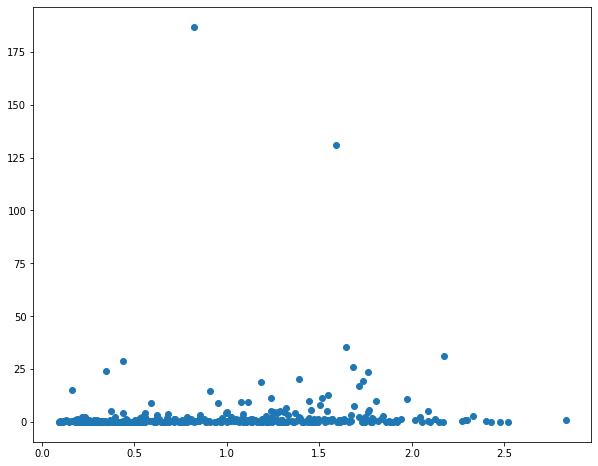

In [ ]:
perpl = 200

fig, ax = plt.subplots(figsize=(10, 8))
#tsne_data = TSNE(n_components=2, perplexity=perpl, random_state=2029256, init="pca", method='barnes_hut').fit_transform(data_derMR)
scat = ax.scatter(data_derMR[:,0],data_derMR[:,1])

=============================   1 clusters found   ============================


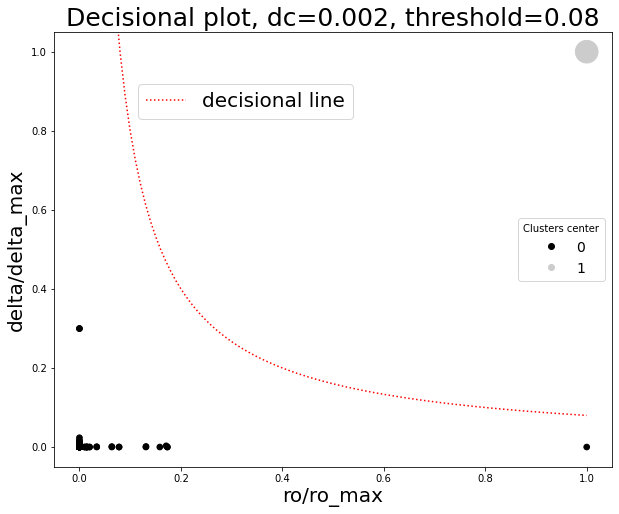

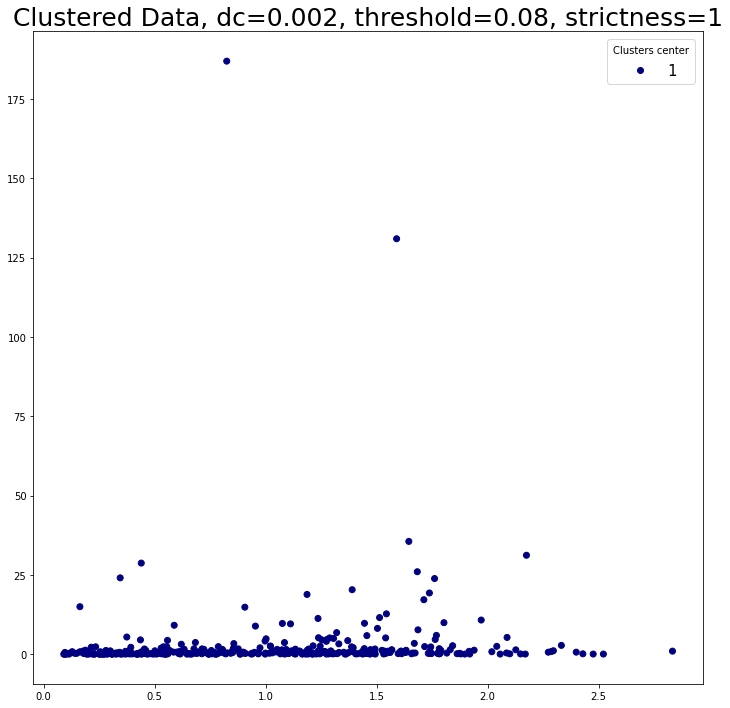

----- WARNING: there is not a border region for cluster nr.1 ------


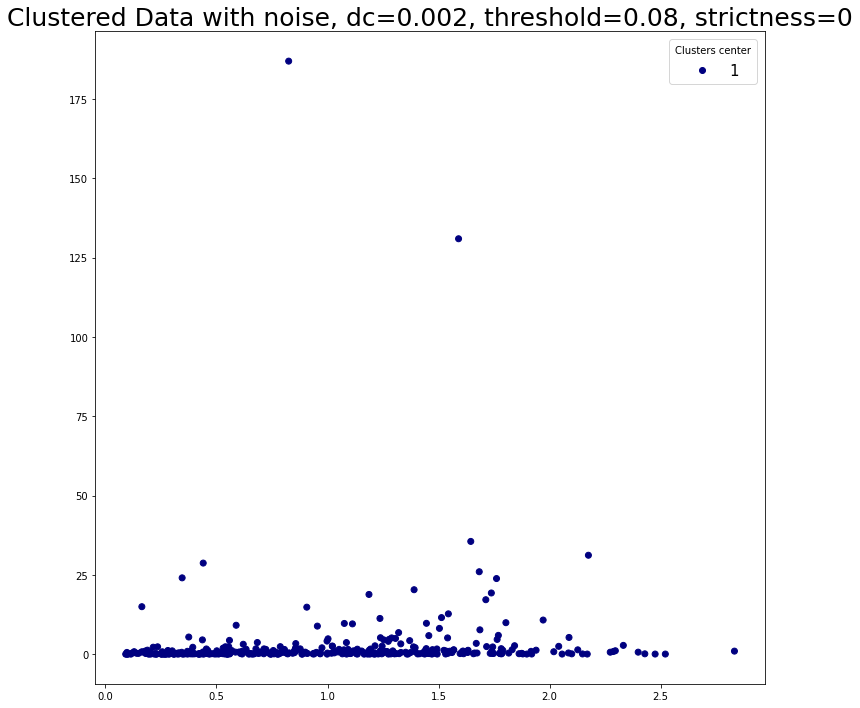

In [ ]:
# clustering on tsne data
# BBR = RLclustering(tsne_data)

# clustering on original data
BBR = RLclustering(data_derMR)

dc = 0.002
threshold = 0.08

#dc = 0.02
#threshold = 0.08

BBR.clear_label()
BBR.ro_delta_graph(dc,gau_chi,threshold)
BBR.clusters_graph(dc,gau_chi,threshold, tsne_perplexity=perpl)
BBR.clusters_graph(dc,gau_chi,threshold, strictness=0, noise=True, tsne_perplexity=perpl);

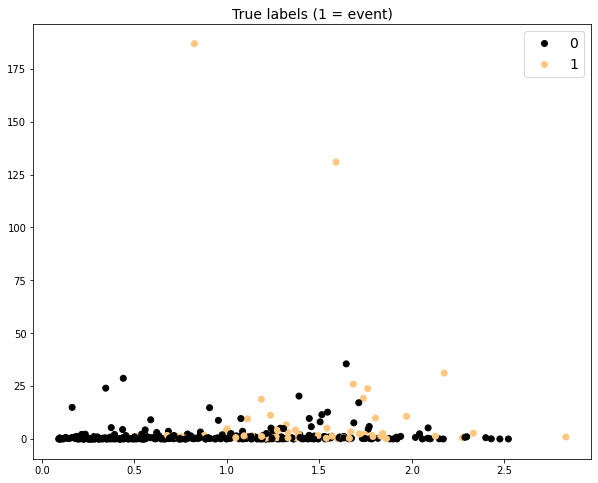

In [ ]:
# FINDING TRUE LABELS    1 = EVENT WITH VISITORS   0 = NO EVENT, NO VISITORS

event_labels = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1            # day 1 is element 0
event_labels[event_days] = 1

for i in range(365):
  filtered_data = df_in[df_in["Day_number"]==i+1]
  month_labels[i] = list(filtered_data['Data'])[0].timetuple().tm_mon
 
tsne_data = TSNE(n_components=2, perplexity=perpl, random_state=2029256, init = "pca",method='barnes_hut').fit_transform(data_derMR)

cmap = plt.cm.copper
cmaplist = [plt.cm.copper(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
fig, ax = plt.subplots(figsize=(10, 8))


scat = ax.scatter(data_derMR[:,0],data_derMR[:,1],c=event_labels,label=event_labels,cmap=cmap)
ax.set_title("True labels (1 = event)", fontsize=14)
ax.legend(*scat.legend_elements(),  loc='best', fontsize=14);

In [ ]:
# From clustering is visible that most isolated cluster is number 1
predicted_labels = BBR.get_labels()== 1

predicted = np.sum(predicted_labels)
correct = np.sum(event_labels*predicted_labels)
total = len(event_days)

print("precision:",correct/predicted)
print("recall:",correct/total)

# This method has nice precision, but is not able to recognize most of the events. Why are some of them so difficult to deparate from the others?

precision: 0.1780821917808219
recall: 1.0


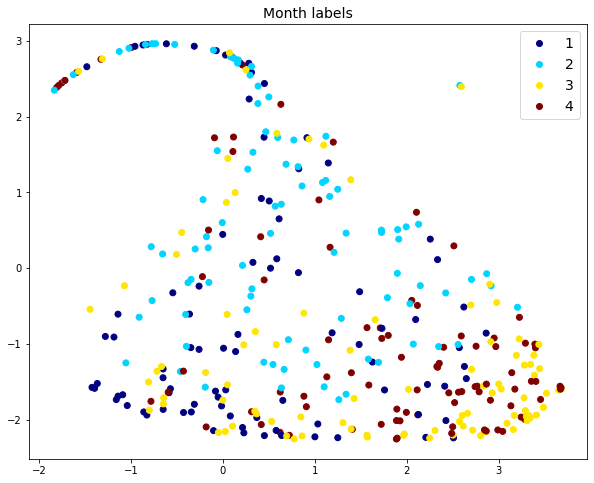

In [ ]:
cmap = plt.cm.jet
cmaplist = [plt.cm.jet(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
fig, ax = plt.subplots(figsize=(10, 8))

season_lables = np.zeros(N)

for k in range(len(month_labels)):
  if month_labels[k] == 1 or month_labels[k] == 2 or month_labels[k] == 12 :
    season_lables[k] = 4
  if month_labels[k] == 4 or month_labels[k] == 5 or month_labels[k] == 3 :
    season_lables[k] = 1
  if month_labels[k] == 6 or month_labels[k] == 7 or month_labels[k] == 8 :
    season_lables[k] = 2
  if month_labels[k] == 10 or month_labels[k] == 11 or month_labels[k] == 9 :
    season_lables[k] = 3


scat = ax.scatter(tsne_data[:,0],tsne_data[:,1],c=season_lables,label=season_lables,cmap=cmap)
ax.set_title("Month labels", fontsize=14)
ax.legend(*scat.legend_elements(),  loc='best', fontsize=14);

# IT'S THE FINAL CLUSTER DOWN

In [ ]:
termo_ringebu = np.asarray([2,3,21,26,31,52,54,63,68,87,92,95,102,104,106,108,111,114,116,118,126,130,132,135,143,146,152,244,249,256,
                 263,265,279,284,295,300,305,307,312,321,324,325,326,327,328,329,331,333,335,344,351,353,355,356,358,359,363])

inverno_ringebu = np.asarray([105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258])

## Clustering australia (best)



In [ ]:
data = np.vstack((
                      std_der_Tin/np.mean(std_der_Tin),    # Dev std del valore assuluto della derivata di Tin
                      std_diff_MR/np.mean(std_diff_MR),
                      std_der_RHin/np.mean(std_der_RHin),          # Dev std del valore assuluto della derivata di RHin
                      std_MRin/np.mean(std_MRin)           # Dev std del valore assuluto della derivata di MR
                      )).T

df_data = pd.DataFrame(data, columns=['Std_Der_Tin', 'Std_Der_Diff_MR', 'Std_Der_RHin', 'Std_MRin'], index=[i for i in range(365)])

Text(0, 0.5, 'Std_MRin')

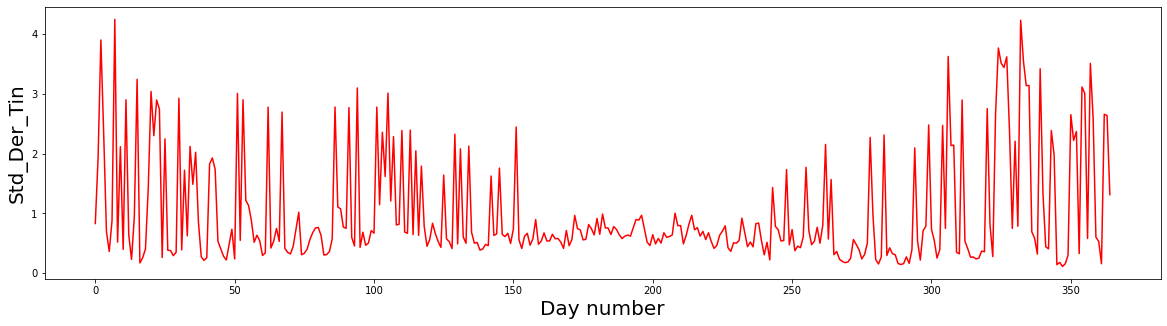

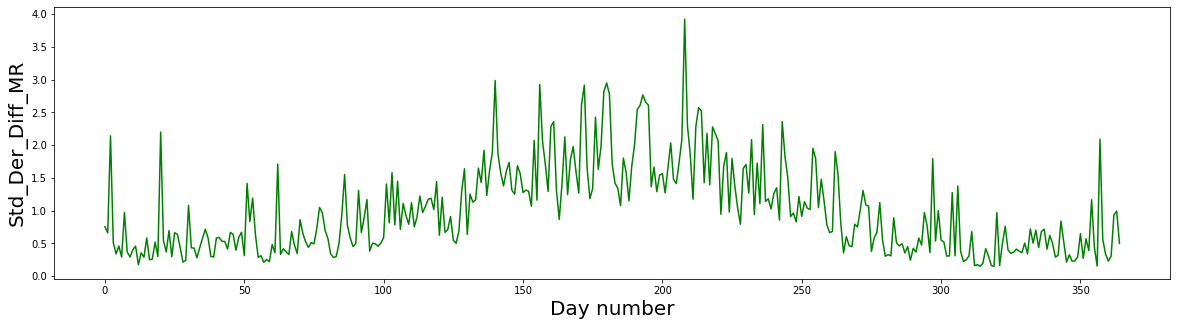

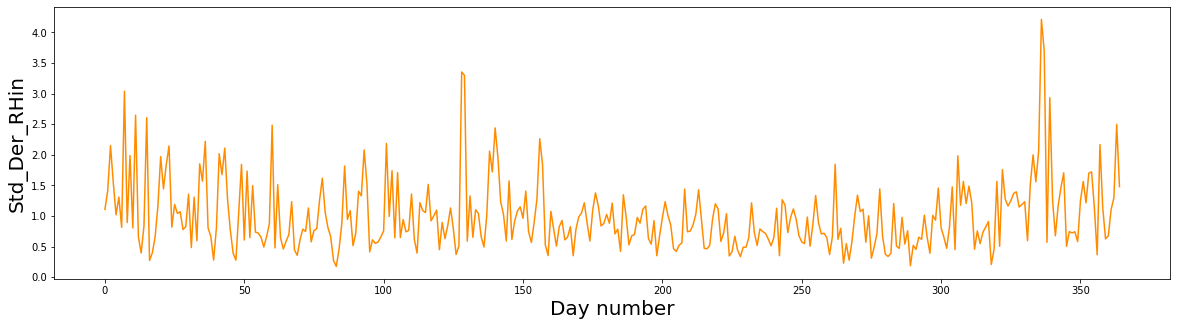

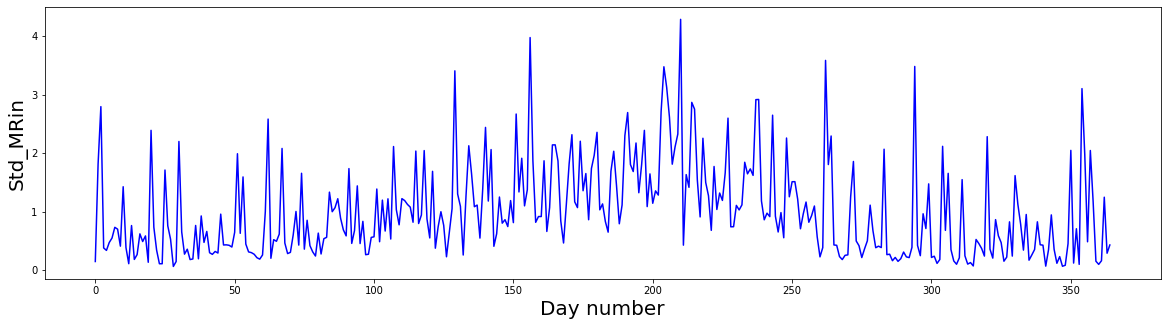

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df_data['Std_Der_Tin'], color='red')
plt.xlabel('Day number', fontsize=20)
plt.ylabel('Std_Der_Tin', fontsize=20)

plt.figure(figsize=(20,5))
plt.plot(df_data['Std_Der_Diff_MR'], color='green')
plt.xlabel('Day number', fontsize=20)
plt.ylabel('Std_Der_Diff_MR', fontsize=20)

plt.figure(figsize=(20,5))
plt.plot(df_data['Std_Der_RHin'], color='darkorange')
plt.xlabel('Day number', fontsize=20)
plt.ylabel('Std_Der_RHin', fontsize=20)

plt.figure(figsize=(20,5))
plt.plot(df_data['Std_MRin'], color='blue')
plt.xlabel('Day number', fontsize=20)
plt.ylabel('Std_MRin', fontsize=20)

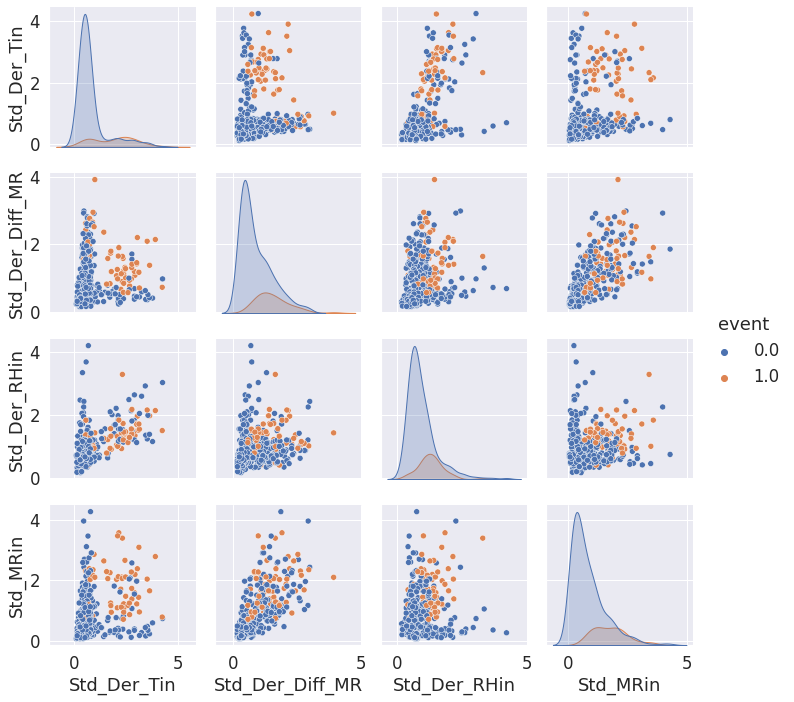

In [ ]:
event_labels = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1            # day 1 is element 0
termo_ringebu = termo_ringebu - 1
inverno_ringebu = inverno_ringebu - 1 

event_labels[event_days]=1


#event_labels[inverno_ringebu] = 0
#event_labels[termo_ringebu] = 0

df_data['event'] = event_labels
sns.set(font_scale=1.5) 
sns.pairplot(df_data, hue='event');

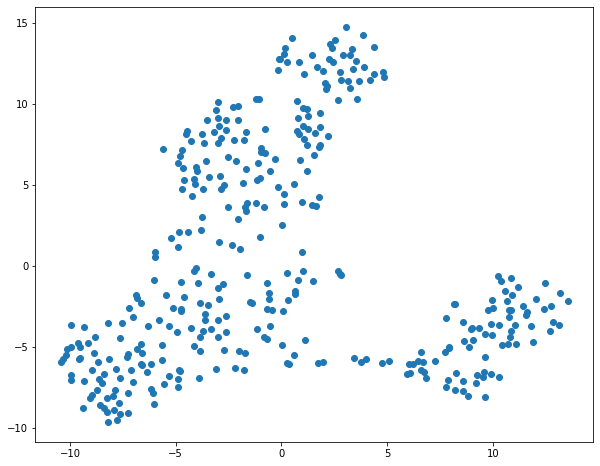

In [ ]:
perpl = 50

fig, ax = plt.subplots(figsize=(10, 8))
tsne_data = TSNE(n_components=2, perplexity=perpl, random_state=2029256, init="pca", method='barnes_hut').fit_transform(data)
scat = ax.scatter(tsne_data[:,0],tsne_data[:,1])

=============================   2 clusters found   ============================


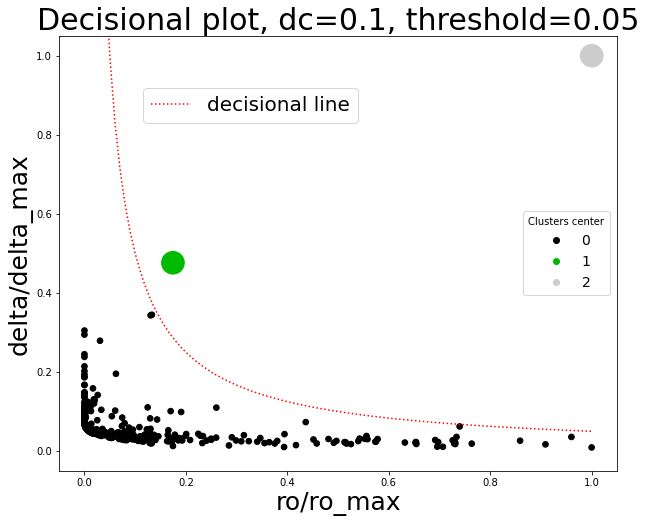

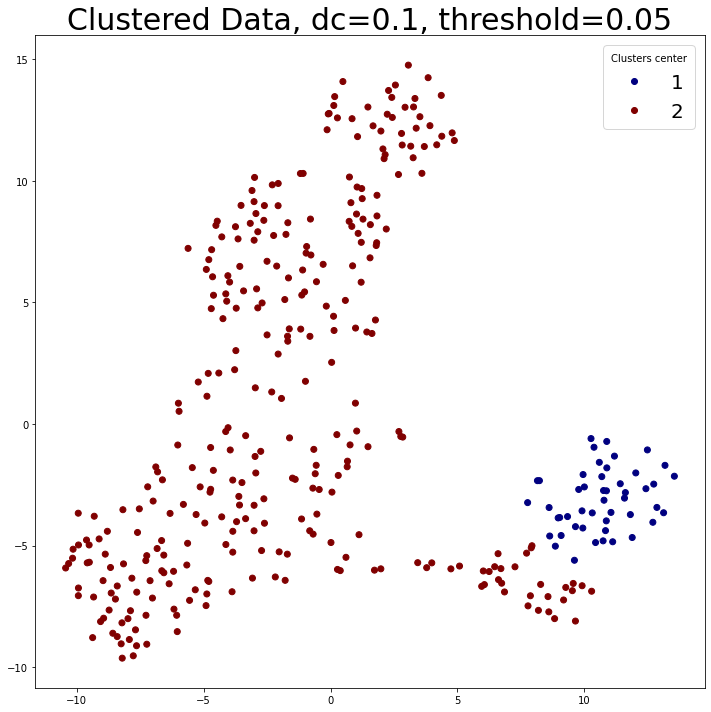

----- WARNING: there is not a border region for cluster nr.1 ------
----- WARNING: there is not a border region for cluster nr.2 ------


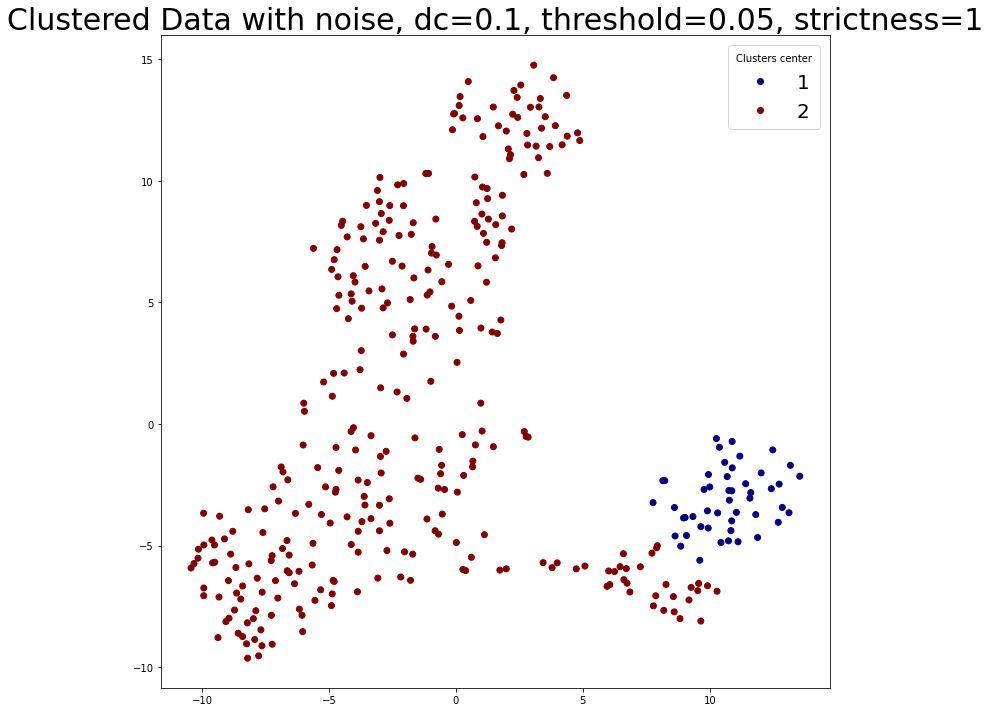

In [ ]:
# clustering on tsne data
# BBR = RLclustering(tsne_data)

# clustering on original data
BBR = RLclustering(data)

dc = 0.1
threshold = 0.05


BBR.clear_label()
BBR.ro_delta_graph(dc,gau_chi,threshold)
BBR.clusters_graph(dc,gau_chi,threshold, tsne_perplexity=perpl)
BBR.clusters_graph(dc,gau_chi,threshold, strictness=1, noise=True, tsne_perplexity=perpl);

### comparison with metadata

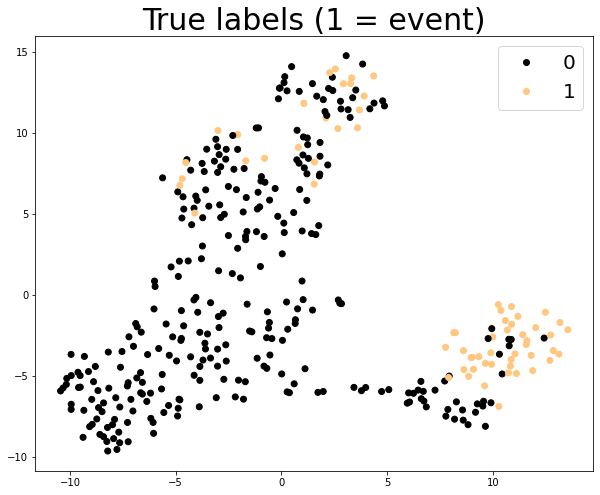

In [ ]:
# FINDING TRUE LABELS    1 = EVENT WITH VISITORS   0 = NO EVENT, NO VISITORS


for i in range(365):
  filtered_data = df_in[df_in["Day_number"]==i+1]
  month_labels[i] = list(filtered_data['Data'])[0].timetuple().tm_mon
 
tsne_data = TSNE(n_components=2, perplexity=perpl, random_state=2029256, init = "pca",method='barnes_hut').fit_transform(data)

cmap = plt.cm.copper
cmaplist = [plt.cm.copper(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
fig, ax = plt.subplots(figsize=(10, 8))


scat = ax.scatter(tsne_data[:,0],tsne_data[:,1],c=event_labels,label=event_labels,cmap=cmap)
ax.set_title("True labels (1 = event)", fontsize=30)
ax.legend(*scat.legend_elements(),  loc='best', fontsize=20);

In [ ]:
# From clustering is visible that most isolated cluster is number 1
predicted_labels = BBR.get_labels() == 1
predicted_all = BBR.get_labels()

predicted = np.sum(predicted_labels)
correct = np.sum(event_labels*predicted_labels)
total = np.sum(event_labels)

NMI_tr = normalized_mutual_info_score(event_labels, predicted_all)
print('NMI:', NMI_tr)
print("precision:",correct/predicted)
print("recall:",correct/total)

# This method has nice precision, but is not able to recognize most of the events. Why are some of them so difficult to deparate from the others?

NMI: 0.39530255824868354
precision: 0.8333333333333334
recall: 0.6153846153846154


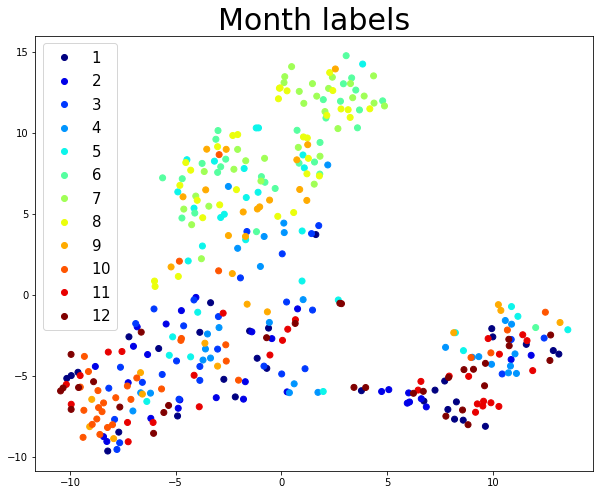

In [ ]:
cmap = plt.cm.jet
cmaplist = [plt.cm.jet(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
fig, ax = plt.subplots(figsize=(10, 8))


scat = ax.scatter(tsne_data[:,0],tsne_data[:,1],c=month_labels,label=month_labels,cmap=cmap)
ax.set_title("Month labels", fontsize=30)
ax.legend(*scat.legend_elements(),  loc='best', fontsize=15);

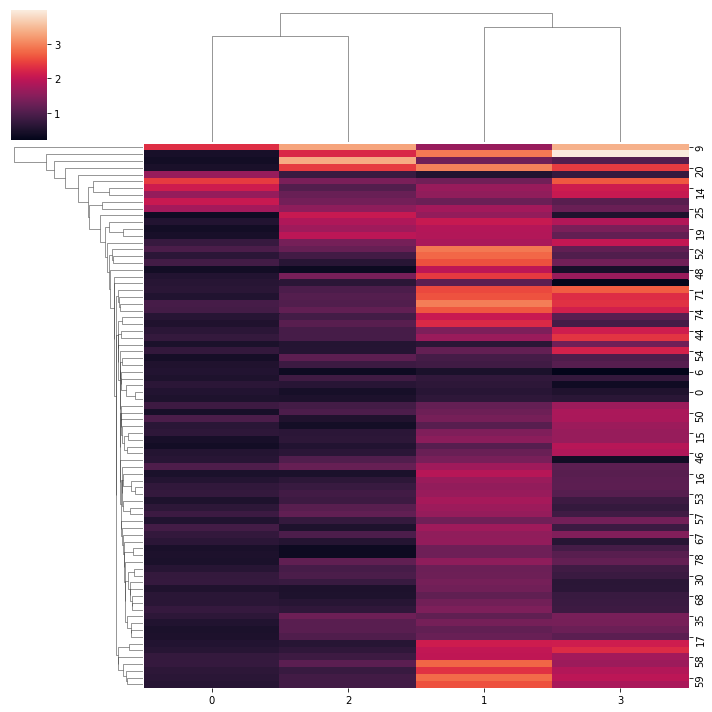

In [ ]:
sns.clustermap(data[120:200,:], method='single')

## Clustering Africa



In [ ]:
#africa
data = np.vstack((
                      std_der_Tin/np.mean(std_der_Tin),    # Dev std del valore assuluto della derivata di Tin
                      #std_diff_MR/np.mean(std_diff_MR),
                      std_der_RHin/np.mean(std_der_RHin),          # Dev std del valore assuluto della derivata di RHin
                      std_der_MRin/np.mean(std_der_MRin)           # Dev std del valore assuluto della derivata di MR       
                      )).T

df_data = pd.DataFrame(np.log(data))

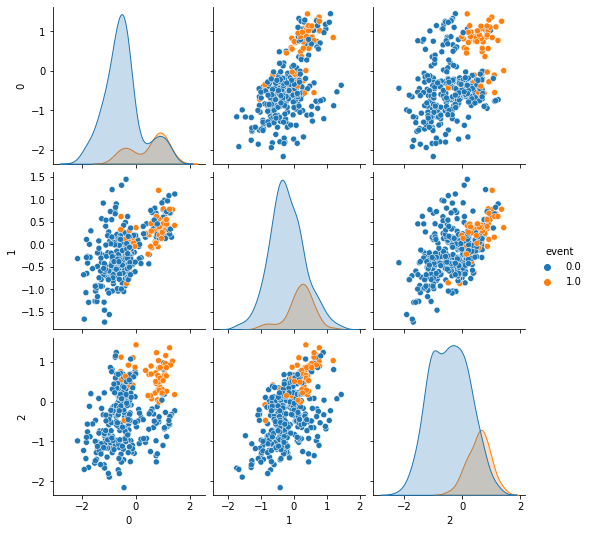

In [ ]:
event_labels = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1
event_labels[event_days]=1

df_data['event'] = event_labels
sns.pairplot(df_data, hue='event')

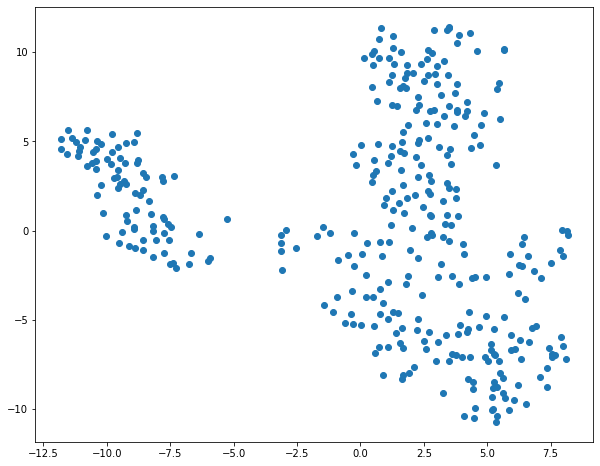

In [ ]:
data = np.log(data)

perpl = 60

fig, ax = plt.subplots(figsize=(10, 8))
tsne_data = TSNE(n_components=2, perplexity=perpl, random_state=2029256, init="pca", method='barnes_hut').fit_transform(data)
scat = ax.scatter(tsne_data[:,0],tsne_data[:,1])

=============================   2 clusters found   ============================


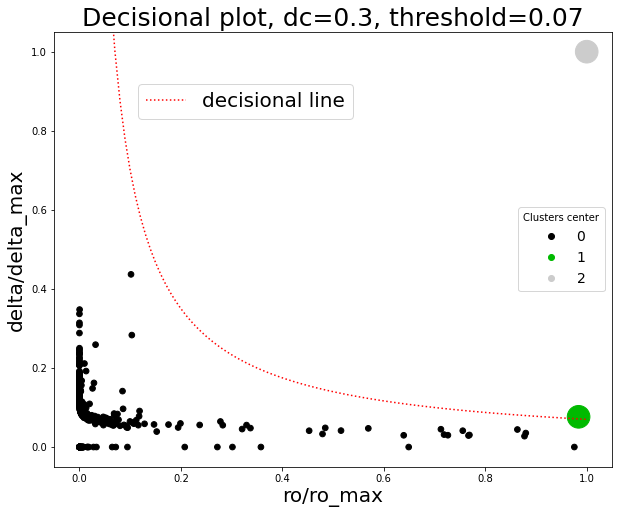

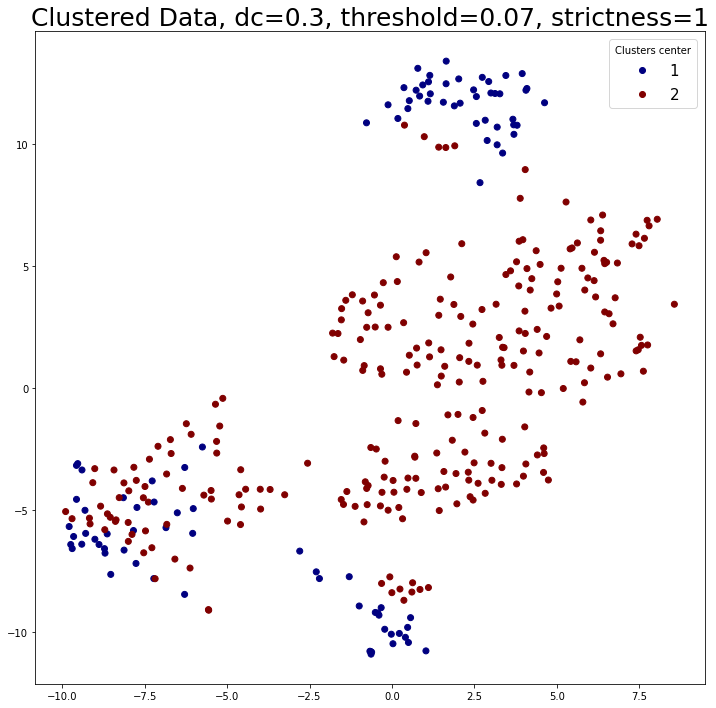

----- WARNING: there is not a border region for cluster nr.1 ------
----- WARNING: there is not a border region for cluster nr.2 ------


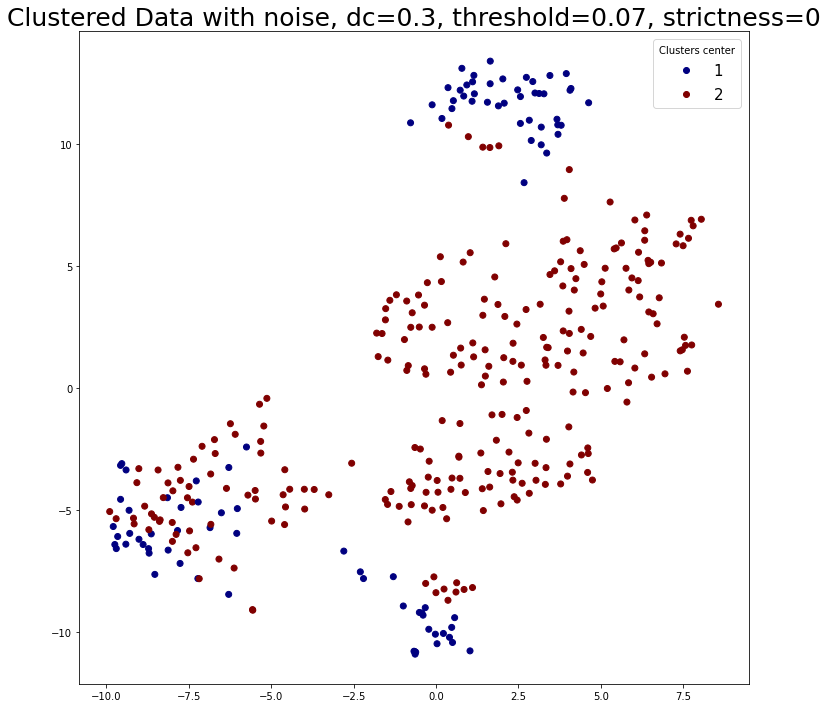

In [ ]:
# clustering on tsne data
# BBR = RLclustering(tsne_data)

# clustering on original data
BBR = RLclustering(df_data_season)

dc = 0.3
threshold = 0.07

BBR.clear_label()
BBR.ro_delta_graph(dc,gau_chi,threshold)
BBR.clusters_graph(dc,gau_chi,threshold, tsne_perplexity=perpl)
BBR.clusters_graph(dc,gau_chi,threshold, strictness=0, noise=True, tsne_perplexity=perpl);

### comparison with metadata

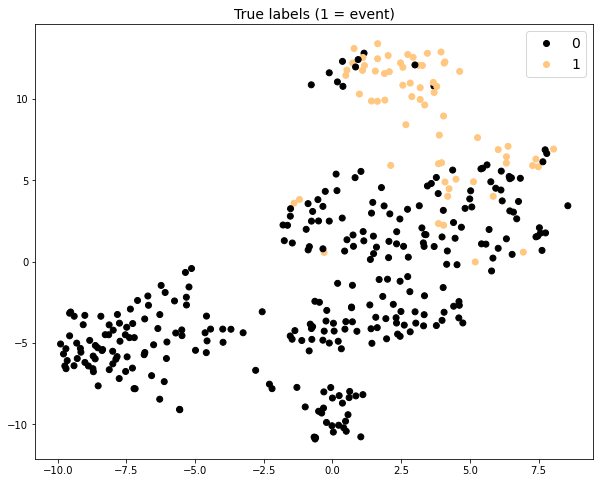

In [ ]:
# FINDING TRUE LABELS    1 = EVENT WITH VISITORS   0 = NO EVENT, NO VISITORS

event_labels = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1            # day 1 is element 0
event_labels[event_days]=1

for i in range(365):
  filtered_data = df_in[df_in["Day_number"]==i+1]
  month_labels[i] = list(filtered_data['Data'])[0].timetuple().tm_mon
 
tsne_data = TSNE(n_components=2, perplexity=perpl, random_state=2029256, init = "pca",method='barnes_hut').fit_transform(df_data_season)

cmap = plt.cm.copper
cmaplist = [plt.cm.copper(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
fig, ax = plt.subplots(figsize=(10, 8))


scat = ax.scatter(tsne_data[:,0],tsne_data[:,1],c=event_labels,label=event_labels,cmap=cmap)
ax.set_title("True labels (1 = event)", fontsize=14)
ax.legend(*scat.legend_elements(),  loc='best', fontsize=14);

In [ ]:
# From clustering is visible that most isolated cluster is number 1
predicted_labels = BBR.get_labels() == 1
predicted_all = BBR.get_labels()

predicted = np.sum(predicted_labels)
correct = np.sum(event_labels*predicted_labels)
total = len(event_days)

NMI_tr = normalized_mutual_info_score(event_labels, predicted_all)
print('NMI:', NMI_tr)
print("precision:",correct/predicted)
print("recall:",correct/total)

NMI: 0.0636044615050257
precision: 0.35051546391752575
recall: 0.5230769230769231


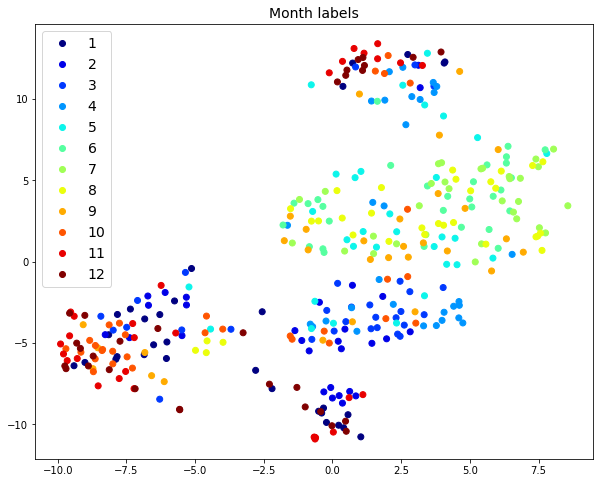

In [ ]:
cmap = plt.cm.jet
cmaplist = [plt.cm.jet(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
fig, ax = plt.subplots(figsize=(10, 8))


scat = ax.scatter(tsne_data[:,0],tsne_data[:,1],c=month_labels,label=month_labels,cmap=cmap)
ax.set_title("Month labels", fontsize=14)
ax.legend(*scat.legend_elements(),  loc='best', fontsize=14);

## -------------- Another Cluster in the code --------------

In [ ]:
event_labels = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1            # day 1 is element 0
event_labels[event_days]=1

### K-Mean

NMI: 0.2155886270201785
precision: 0.5443037974683544
recall: 0.6615384615384615


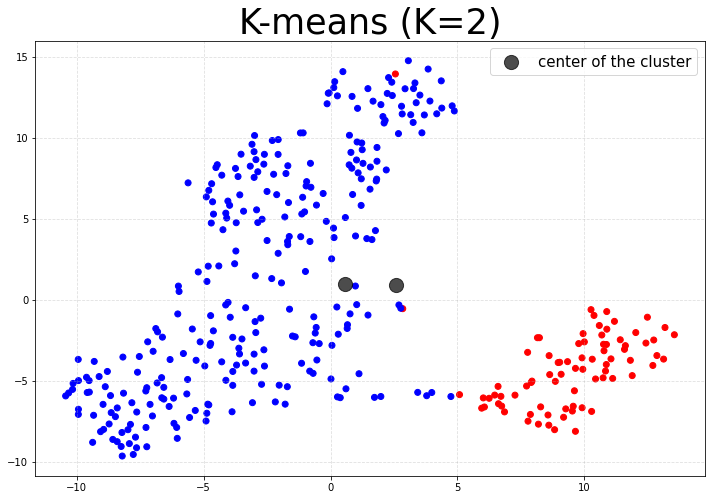

In [ ]:
kmeans =  KMeans(n_clusters=2, n_init=100, max_iter=300, tol=0.0001, random_state=2029256)
kmeans.fit(data)

k_col = []
for l in range(len(kmeans.labels_)):
    if kmeans.labels_[l] == 0 : k_col.append('blue')
    if kmeans.labels_[l] == 1 : k_col.append('red')
    if kmeans.labels_[l] == 2 : k_col.append('green')

###############################################################################################################################################

#evaluate performances
predicted = np.sum(kmeans.labels_)
correct = np.sum(event_labels*kmeans.labels_)
total = np.sum(event_labels)

NMI_tr = normalized_mutual_info_score(event_labels, kmeans.labels_)
print('NMI:', NMI_tr)
print("precision:",correct/predicted)
print("recall:",correct/total)

###############################################################################################################################################

#plot the results
X_red = TSNE(n_components=2, perplexity=50, random_state=2029256, method='barnes_hut', init='pca').fit_transform(data)

fig = plt.figure(figsize=(12,8))
plt.scatter(X_red[:,0], X_red[:,1], c=k_col, alpha=1)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', s=200, zorder=10, alpha=0.7, label='center of the cluster')
plt.title('K-means (K=2)', fontsize=35)
plt.legend(loc='best', fontsize=15)
plt.grid(linestyle='--', alpha=0.4);

### Agglomerative cluster

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print(recall_score(event_labels, db.labels_, average='binary'))
print(precision_score(event_labels, db.labels_, average='binary'))

0.6
0.6290322580645161


NMI: 0.24551693624168036
precision: 0.6290322580645161
recall: 0.6


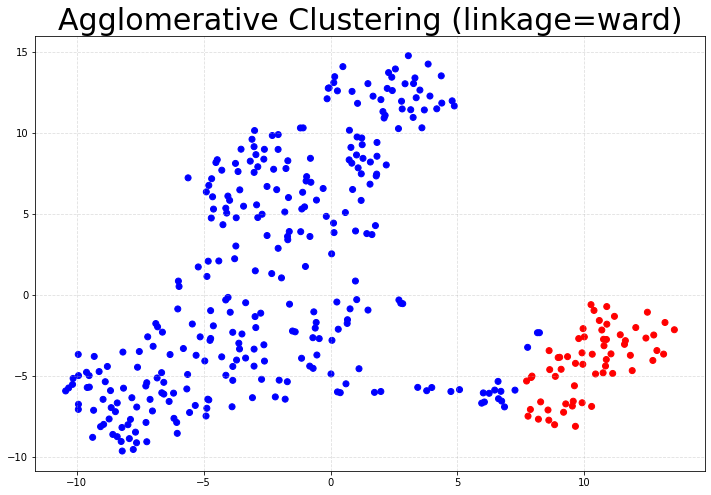

In [ ]:
db = AgglomerativeClustering(n_clusters=2, linkage='ward') #‘ward’ minimizes the variance of the clusters being merged
db.fit(data)

lb_col = []
for l in range(len(db.labels_)):
    if db.labels_[l] == 0 : lb_col.append('blue')
    if db.labels_[l] == 1 : lb_col.append('red')
    if db.labels_[l] == 2 : lb_col.append('green')

###############################################################################################################################################

#evaluate performances
predicted = np.sum(db.labels_)
correct = np.sum(event_labels*db.labels_)
total = np.sum(event_labels)

NMI_tr = normalized_mutual_info_score(event_labels, db.labels_)
print('NMI:', NMI_tr)
print("precision:",correct/predicted)
print("recall:",correct/total)

###############################################################################################################################################

#plot the results
X_red = TSNE(n_components=2, perplexity=50, random_state=2029256, method='barnes_hut', init='pca').fit_transform(data)

#plot the results
fig = plt.figure(figsize=(12,8))
plt.scatter(X_red[:,0], X_red[:,1], c=lb_col, alpha=1)
plt.title('Agglomerative Clustering (linkage=ward)', fontsize=30)
plt.grid(linestyle='--', alpha=0.4);

### DBSCAN

NMI: 0.13936636078864542
precision: 0.4142857142857143
recall: -0.4461538461538462


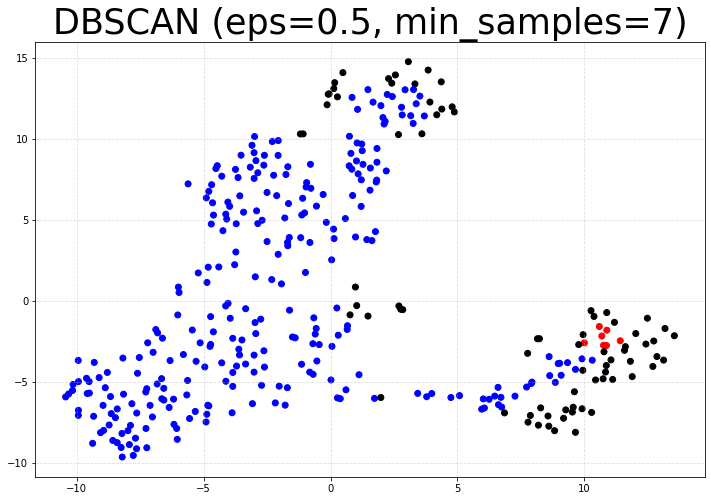

In [ ]:
model = DBSCAN(eps=0.5, min_samples=7)
model.fit(data)

lb_col = []
for l in range(len(model.labels_)):
    if model.labels_[l] == -1 : lb_col.append('black')
    if model.labels_[l] == 0 : lb_col.append('blue')
    if model.labels_[l] == 1 : lb_col.append('red')
    if model.labels_[l] == 2 : lb_col.append('green')
    if model.labels_[l] == 3 : lb_col.append('orange')

###############################################################################################################################################

#evaluate performances

predicted = np.sum(model.labels_)
correct = np.sum(event_labels*model.labels_)
total = np.sum(event_labels)

NMI_tr = normalized_mutual_info_score(event_labels, model.labels_)
print('NMI:', NMI_tr)
print("precision:",correct/predicted)
print("recall:",correct/total)

###############################################################################################################################################

#plot the results
X_red = TSNE(n_components=2, perplexity=50, random_state=2029256, method='barnes_hut', init='pca').fit_transform(data)

#plot the results
fig = plt.figure(figsize=(12,8))
plt.scatter(X_red[:,0], X_red[:,1], c=lb_col, alpha=1)
plt.title('DBSCAN (eps=0.5, min_samples=7)', fontsize=35)
plt.grid(linestyle='--', alpha=0.4);

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

model.labels_[model.labels_ == -1] = 0
print(recall_score(event_labels, model.labels_, average='binary'))
print(precision_score(event_labels, model.labels_, average='binary'))

0.07692307692307693
0.7142857142857143


## HEDDAL TIME

In [ ]:
days = ("monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday") 

# indoor
df_in = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Heddal/Heddal_DL1_year.csv" ,names=['n','Data', 'RH', 'T'],header=0)
df_mr = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Heddal/mixing_ratio_DL1_year.csv" ,names=['n','Data', 'MR'],header=0)
df_in2 = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Heddal/Heddal_DL2_year.csv" ,names=['n','Data', 'RH', 'T'],header=0)
df_mr2 = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Heddal/mixing_ratio_DL2_year.csv" ,names=['n','Data', 'MR'],header=0)
# outdoor
df_out = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Heddal/Heddal_DL3_year.csv" ,names=['n','Data', 'RH', 'T'],header=0)
df_mr3 = pd.read_csv( "/content/drive/MyDrive/LOCP(B)/Heddal/mixing_ratio_DL3_year.csv" ,names=['n','Data', 'MR'],header=0)
    
metadata_df = pd.read_excel( "/content/drive/MyDrive/LOCP(B)/Heddal/Metadata_Events.xlsx" ,
                          names=['c',"Data","Duration","Time","People"],header=0)

metadata_df['Data'] = pd.to_datetime(metadata_df['Data'], format='%m/%d/%Y')
metadata_df['Day_number'] = [  metadata_df['Data'][i].timetuple().tm_yday  for i in range(len(metadata_df['Data']))]


# converting string do datetime
df_in['Data'] = pd.to_datetime(df_in['Data'], format='%Y-%m-%d %H:%M:%S')
df_in2['Data'] = pd.to_datetime(df_in2['Data'], format='%Y-%m-%d %H:%M:%S')
df_out['Data'] = pd.to_datetime(df_out['Data'], format='%Y-%m-%d %H:%M:%S')

# creating new colums
df_in['Day_number'] = [  df_in['Data'][i].timetuple().tm_yday  for i in range(len(df_in['Data']))]
df_in['MR'] = df_mr['MR']

#df_in2['Day'] = [ days[ df_in['Data'][i].weekday() ] for i in range(len(df_in['Data']))]
df_in2['Day_number'] = [  df_in2['Data'][i].timetuple().tm_yday  for i in range(len(df_in2['Data']))]
df_in2['MR'] = df_mr2['MR']

#df_out['Day'] = [ days[ df_out['Data'][i].weekday() ] for i in range(len(df_out['Data']))]
df_out['Day_number'] = [  df_out['Data'][i].timetuple().tm_yday  for i in range(len(df_out['Data']))]
df_out['MR'] = df_mr3['MR']

In [ ]:
din = df_in[df_in["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
dout = df_out[df_out["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
din2 = df_in[df_in2["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]

heddal_in = df_in[df_in["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
dout = df_out[df_out["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
din2 = df_in[df_in2["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]

x = np.unique(din["Day_number"])
N = len(x)

# Possibili variabili da clusterizzare 
std_Tin = np.zeros(N)        # dev std di Tin 
std_Tout = np.zeros(N)       # dev std di Tout 
std_RHin = np.zeros(N)       # dev std di RHin
std_MRin = np.zeros(N)       # dev std di MRin 
std_MRout = np.zeros(N)       # dev std di MRout
std_RHout = np.zeros(N)       # dev std di RHout
std_diff_T = np.zeros(N)     # dev std di Tin-Tout
std_diff_RH = np.zeros(N)    # dev std di RHin-RHout
std_diff_MR = np.zeros(N)    # dev std di MRin-MRout
mean_Tout = np.zeros(N)       #mean di Tout

std_der_Tin = np.zeros(N)    # dev std of T derivative
std_der_Tin2 = np.zeros(N)    # dev std of T derivative sensore 2
std_der_MRin = np.zeros(N)    # dev std of MR derivative
std_der_MRin2 = np.zeros(N)    # dev std of MR derivative sensore 2
std_der_RHin = np.zeros(N)    # dev std of RH derivative
std_der_Tout = np.zeros(N)    # dev std of T derivative
std_der_MRout = np.zeros(N)    # dev std of MR derivative
std_der_RHout = np.zeros(N)    # dev std of RH derivative

std_der_diff_T = np.zeros(N)
std_der_diff_RH = np.zeros(N)
std_der_diff_MR = np.zeros(N)
std_der_MR = np.zeros(N)     # dev std of MR derivative

std_sumdiff_der_MR = np.zeros(N)


for i in range(N):
    data_in = din[din["Day_number"]==i+1]
    data_in2 = din2[din2["Day_number"]==i+1]
    data_out = dout[dout["Day_number"]==i+1]

    std_der_Tin[i] = np.std( finite_derivative( np.asarray(data_in["T"]) ))
    std_der_Tin2[i] = np.std( finite_derivative( np.asarray(data_in2["T"]) )) #sensore 2 
    std_der_MRin2[i] = np.std( finite_derivative( np.asarray(data_in2["MR"]) )) #sensore 2 
    std_der_MRin[i] = np.std( finite_derivative( np.asarray(data_in["MR"]) ))
    std_der_RHin[i] = np.std( finite_derivative( np.asarray(data_in["RH"]) ))
    std_der_Tout[i] = np.std( finite_derivative( np.asarray(data_out["T"]) )) 
    std_der_MRout[i] = np.std( finite_derivative( np.asarray(data_out["MR"]) ))
    std_der_RHout[i] = np.std( finite_derivative( np.asarray(data_out["RH"]) ))  
    std_der_MR[i] = np.std( abs(finite_derivative( np.asarray(data_in["MR"]) )) )
    
    mean_Tout[i] = np.mean(np.asarray(data_out["T"]))
    std_Tin[i] = np.std( np.asarray(data_in["T"]) )
    std_MRin[i] = np.std( np.asarray(data_in["MR"]) )
    std_MRout[i] = np.std( np.asarray(data_out["MR"]) )
    std_Tout[i] = np.std( np.asarray(data_out["T"]) )
    std_RHin[i] = np.std( np.asarray(data_in["RH"]) )
    std_RHout[i] = np.std( np.asarray(data_out["RH"]) )
    std_diff_T[i] = np.std( data_in["T"] - data_out["T"] )
    std_diff_RH[i] = np.std( data_in["RH"] - data_out["RH"] )
    std_diff_MR[i] = np.std( finite_derivative( np.asarray( data_in["MR"] - data_out["MR"] )))
    
    std_der_diff_T[i] = np.std( finite_derivative( np.asarray( data_in["T"]-data_out["T"] ) )) 
    std_der_diff_RH[i] = np.std( finite_derivative( np.asarray( data_in["RH"]-data_out["RH"] ) )) 
    std_der_diff_MR[i] = np.std( finite_derivative( np.asarray( data_in["MR"]-data_out["MR"] ) ))
    std_sumdiff_der_MR[i] = np.std(abs(finite_derivative(np.asarray(data_in["MR"])) * finite_derivative(np.asarray(data_in2["MR"]))) - abs(finite_derivative(np.asarray(data_out["MR"])))) 

In [ ]:
# cerchiamo giorni sospetti

# there can be only one day number 89 (see df_in printed before)
# il problema e' che il 2020 e' un anno bisestile ahah
din = df_in[df_in["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
din2 = df_in2[df_in2["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]
dout = df_out[df_out["Data"] > pd.to_datetime("2019-03-30 23:55:00", format='%Y-%m-%d %H:%M:%S') ]

N = 365

picchi_integral = np.zeros(N)
picchi_std = np.zeros(N)
picchi_MRout = np.zeros(N)
derder2 = []
mrmr = []
picchi_MR = np.zeros(N)


for i in range(N):
  data_in = din[din["Day_number"]==i+1]
  data_in2 = din2[din2["Day_number"]==i+1]
  data_out = dout[dout["Day_number"]==i+1]
    
  t = 100*abs( finite_derivative( np.asarray(data_in["MR"]) )* finite_derivative( np.asarray(data_in2["MR"]) ) )
  derder2.append(t/100)
  mrmr.append(abs( finite_derivative( np.asarray(data_out["MR"]))))
  picchi_std[i] = np.std(t)
  picchi_integral[i] = np.sum(t)
  picchi_MRout[i] = np.sum(yout[i])
  picchi_MR[i] = np.sum(t)/(np.sum(yout[i]))

predicted1 = np.array(np.where(picchi_integral>18)) + 1
print("Giorni sospetti")
print(predicted1)

predicted2 = np.asarray(np.where(picchi_integral>30)) + 1
print("Giorni mooolto sospetti")
print(predicted2)

print("True label")
true_label = np.unique(metadata_df['Day_number'])
print(true_label)

event_labels2 = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1            # day 1 is element 0
event_labels2[event_days]=1


NameError: ignored

### Heddal data analysis

In [ ]:
label = []
for n in df_in['Day_number']:
  if any(n == metadata_df['Day_number']): label.append(1)
  else : label.append(0)

df_in['label'] = label

In [ ]:
ax,fil = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

plt.plot(df_in['Data'], df_in['T'], color='r')
plt.plot(df_in['Data'], df_in['RH'], color='b')
plt.plot(df_in['Data'], df_in['MR'], color='orange')

plt.plot(df_in['Data'], 100*df_in['label'], color='green', alpha=0.3)

#########################################################################################

ax,fil = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

plt.plot(df_in2['Data'], df_in2['T'], color='r')
plt.plot(df_in2['Data'], df_in2['RH'], color='b')
plt.plot(df_in2['Data'], df_in2['MR'], color='orange')

plt.plot(df_in['Data'], 100*df_in['label'], color='green', alpha=0.3)

#########################################################################################

ax,fil = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

plt.plot(df_out['Data'], df_out['T'], color='r')
plt.plot(df_out['Data'], df_out['RH'], color='b')
plt.plot(df_out['Data'], df_out['MR'], color='orange')

plt.plot(df_in['Data'], 100*df_in['label'], color='green', alpha=0.3)

### Clustering



In [ ]:
data = np.vstack((
                      std_der_Tin/np.mean(std_der_Tin),    # Dev std del valore assuluto della derivata di Tin
                      std_diff_MR/np.mean(std_diff_MR),
                      std_der_RHin/np.mean(std_der_RHin),          # Dev std del valore assuluto della derivata di RHin
                      std_MRin/np.mean(std_MRin)           # Dev std del valore assuluto della derivata di MR
                      )).T

df_data = pd.DataFrame(data, columns=['Std_Der_Tin', 'Std_Diff_MR', 'Std_Der_RHin', 'Std_MRin'], index=[i for i in range(365)])

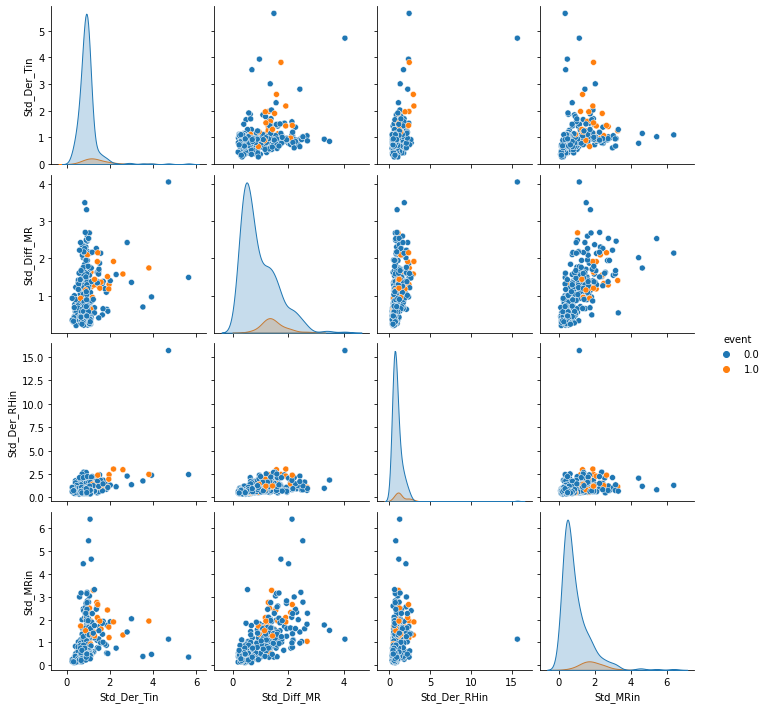

In [ ]:
event_labels2 = np.zeros(N)
month_labels = np.zeros(N)

event_days = np.unique(metadata_df['Day_number'])-1            # day 1 is element 0
event_labels2[event_days]=1

df_data['event'] = event_labels2
sns.pairplot(df_data, hue='event')

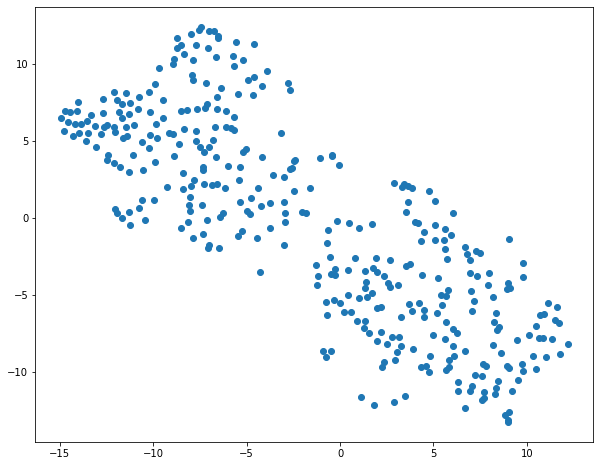

In [ ]:
perpl = 50

fig, ax = plt.subplots(figsize=(10, 8))
tsne_data = TSNE(n_components=2, perplexity=perpl, random_state=2029256, init="pca", method='barnes_hut').fit_transform(data)
scat = ax.scatter(tsne_data[:,0],tsne_data[:,1])

=============================   3 clusters found   ============================


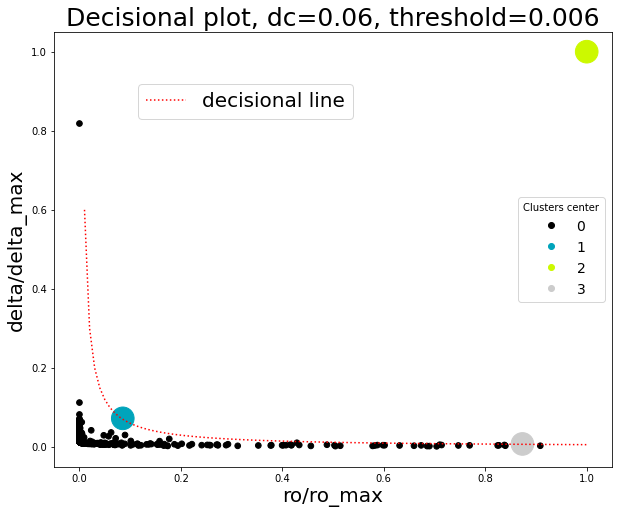

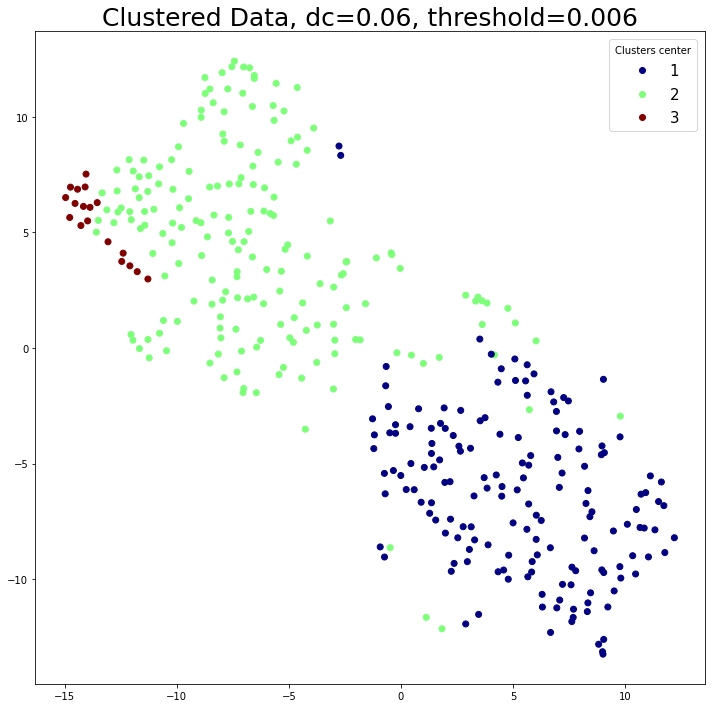

----- WARNING: there is not a border region for cluster nr.1 ------
----- WARNING: there is not a border region for cluster nr.2 ------
----- WARNING: there is not a border region for cluster nr.3 ------


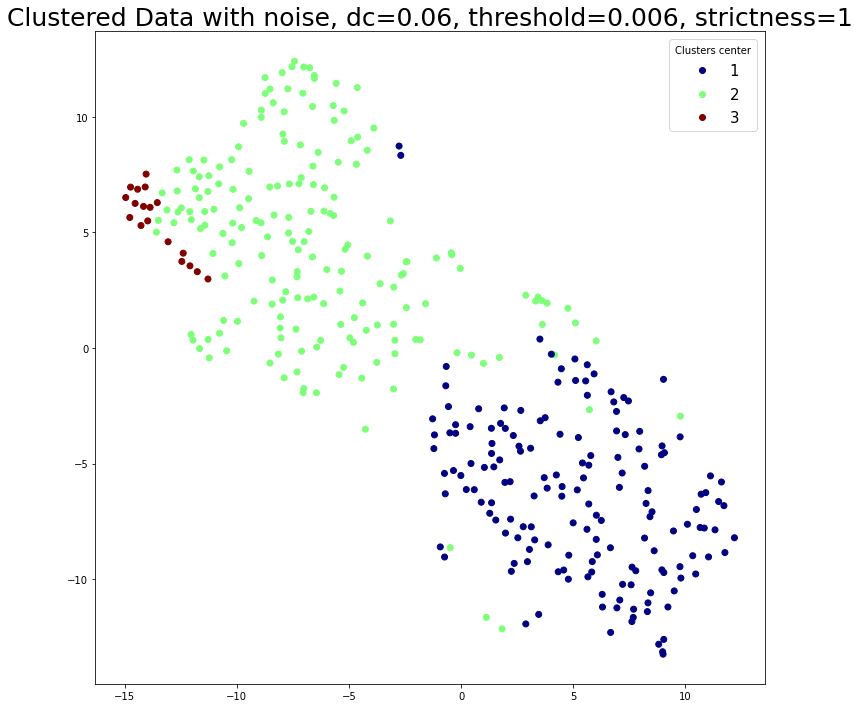

In [ ]:
# clustering on tsne data
# BBR = RLclustering(tsne_data)

# clustering on original data
BBR = RLclustering(data)

dc = 0.06
threshold = 0.006

#dc = 0.02
#threshold = 0.1

BBR.clear_label()
BBR.ro_delta_graph(dc,gau_chi,threshold)
BBR.clusters_graph(dc,gau_chi,threshold, tsne_perplexity=perpl)
BBR.clusters_graph(dc,gau_chi,threshold, strictness=1, noise=True, tsne_perplexity=perpl);

### comparison with metadata

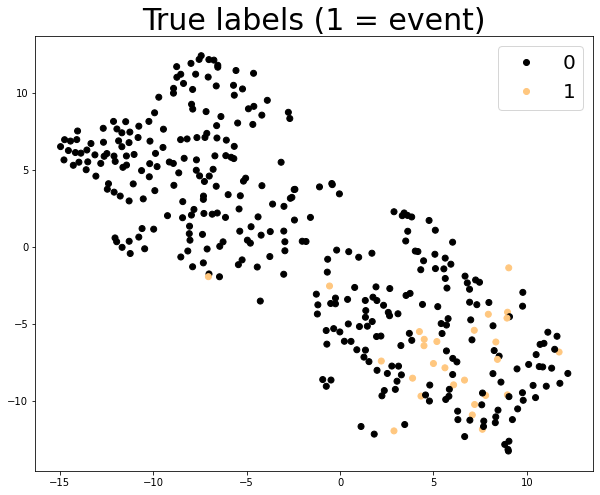

In [ ]:
# FINDING TRUE LABELS    1 = EVENT WITH VISITORS   0 = NO EVENT, NO VISITORS



for i in range(365):
  filtered_data = df_in[df_in["Day_number"]==i+1]
  month_labels[i] = list(filtered_data['Data'])[0].timetuple().tm_mon
 
tsne_data = TSNE(n_components=2, perplexity=perpl, random_state=2029256, init = "pca",method='barnes_hut').fit_transform(data)

cmap = plt.cm.copper
cmaplist = [plt.cm.copper(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
fig, ax = plt.subplots(figsize=(10, 8))


scat = ax.scatter(tsne_data[:,0],tsne_data[:,1],c=event_labels2,label=event_labels2,cmap=cmap)
ax.set_title("True labels (1 = event)", fontsize=30)
ax.legend(*scat.legend_elements(),  loc='best', fontsize=20);

In [ ]:
# From clustering is visible that most isolated cluster is number 1
predicted_labels = BBR.get_labels() == 1
predicted_all = BBR.get_labels()

predicted = np.sum(predicted_labels)
correct = np.sum(event_labels2*predicted_labels)
total = len(event_days)

NMI_tr = normalized_mutual_info_score(event_labels2, predicted_all)
print('NMI:', NMI_tr)
print("precision:",correct/predicted)
print("recall:",correct/total)

# This method has nice precision, but is not able to recognize most of the events. Why are some of them so difficult to deparate from the others?

NMI: 0.09262834793232812
precision: 0.16149068322981366
recall: 0.9629629629629629


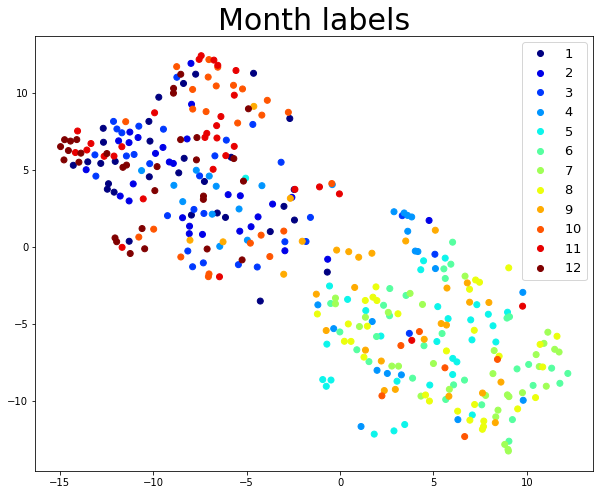

In [ ]:
cmap = plt.cm.jet
cmaplist = [plt.cm.jet(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
fig, ax = plt.subplots(figsize=(10, 8))


scat = ax.scatter(tsne_data[:,0],tsne_data[:,1],c=month_labels,label=month_labels,cmap=cmap)
ax.set_title("Month labels", fontsize=30)
ax.legend(*scat.legend_elements(),  loc='best', fontsize=13);

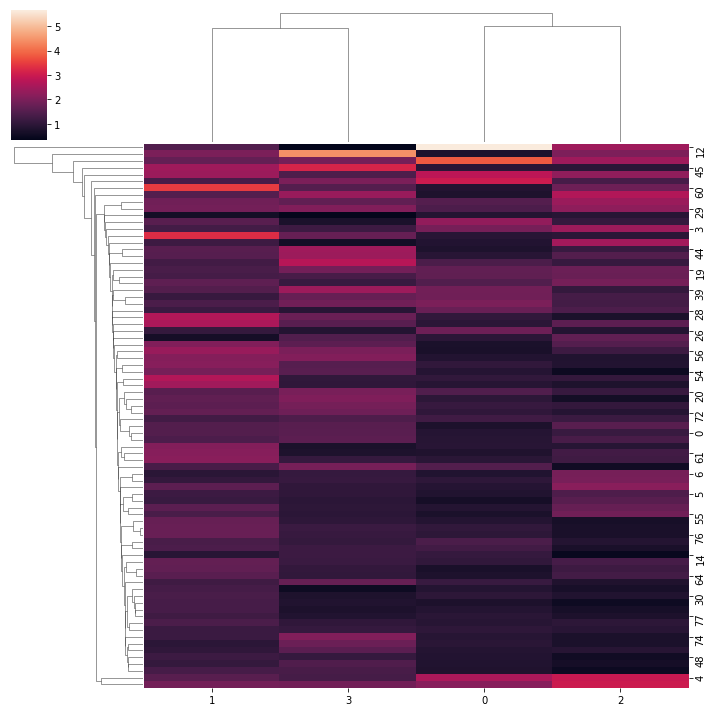

In [ ]:
sns.clustermap(data[120:200,:], method='single')

# BBRNet vs Ringebu (Goku vs Freezer)

## Pre-Pre-processing

In [ ]:
def peaks_df_creation(n_interval_to_mean = 7, MRout_smooth_factor = 3):
    Day_number = df_in["Day_number"]

    # Averaging MRin
    MRin = np.asarray(df_in["MR"])/2 + np.asarray(df_in2["MR"])/2
    MRout = np.asarray(df_out["MR"])

    # Smoothing both MRs. 
    # Tout and RHout is measured every 15 minutes => MRout is updated every 15 minutes.
    # The problem is that MRin is updated every 5 minutes, for thi reason perform a moving average
    # with fixed temporal window does not work properly: MRin becomes much more smoothed than MRout.
    # What is done is consider for both MRs the same number of different measurements before and after the considered
    # point (n_interval_to_mean=7). 
    # This means that we must consider a temporal window three time bigger for MRout (15/5 = 3)
    MRin_smooth = smooth( MRin, n_interval_to_mean )
    MRout_smooth = smooth( MRout , MRout_smooth_factor*n_interval_to_mean )

    der_in = finite_derivative( MRin_smooth ) 
    der_out = finite_derivative( MRout_smooth )


# Notes on derivative:
         # 1 append is necessary because finite derivative kills 4 points.
         # 2 derivative is done with discretization of 5 minutes = 300 s; 
         #   for this reason in order to use SI units we must divide by 300 the two derivates.
         # 3 multiplication by 10^3 (from g to mg of water in MR measurement) -> 3.333 total mult factor.
    y = np.append(np.append((0,0),der_in),(0,0))*3.333
    yout = np.append(np.append((0,0),der_out),(0,0))*3.333


    peaks_df = pd.DataFrame({'Data': df_in["Data"] , 'Day_number': Day_number, 'Tin1' : df_in["T"], 
                         'Tin2' : df_in2["T"],  'Tout' : df_out["T"], 'RHin1' : df_in["RH"],  
                         'RHin2' : df_in2["RH"],  'RHout' : df_out["RH"], 'MRin1': df_in["MR"], 
                         'MRin2': df_in2["MR"], 'MRout': MRout, 'MRin': MRin, 'MRout_smooth': MRout_smooth, 
                         'MRin_smooth': MRin_smooth, 'der_in': y, 'der_out' : yout})
    return peaks_df

#peaks_df = peaks_df_creation()
ringebu_df = peaks_df_creation(df_in, df_in2, df_out)
heddal_df = peaks_df_creation(df_in, df_in2, df_out)

TypeError: ignored

## Pre-Processing

In [ ]:
#y = []
#yout = []
#for i in range(365):
#  df = peaks_df[df_in["Day_number"]==i+1]

#  y.append(np.asarray(df["der_in"]).flatten())
#  yout.append(df["der_out"])

R_data = np.zeros((365,72))
H_data = np.zeros((365,72))

for i in range(365):
    rdf = ringebu_df[df_in["Day_number"]==i+1]
    hdf = heddal_df[heddal_df["Day_number"]==i+1]
    
    R = np.asarray(rdf["MRin_smooth"])
    H = np.asarray(hdf["MRin_smooth"])
    if(i==88):
        R = np.append( np.zeros(12) , R ) 
        H = np.append( np.zeros(13) , H )
    elif(i==89):
        R = np.append( np.zeros(12) , R ) 
        H = np.append( np.zeros(12) , H ) 
    
    R_data[i] = reduction(R,N=4)
    H_data[i] = reduction(H,N=4)



# Merging Heddal and Ringebu data   

x = np.concatenate((R_data,H_data))
categ = np.concatenate((ringebu_event_labels,heddal_event_labels))

N = len(x)
N_categ = 2
y = np.zeros((N, N_categ))
for n in range(N):
    y[n][int(categ[n])] = 1.
    
    
    
# Rescaling the data

xm = x.mean(axis=1) #by the mean->centering into zero
for n in range(N):
    x[n] = x[n]-xm[n] 

In [ ]:
#arrange the data to all same length
x = []
#for i in range(len(derder)):
#  x.append(derder[i][:270])

#for i in range(len(derder2)):
#  x.append(derder2[i][:270])

for i in range(len(y)):
  x.append([y[i][:270], yout[i][:270]])

x = np.array(x)
x = np.swapaxes(x,1,2)
print(x.shape)

In [ ]:
N = len(x)

#Rescaling the data

xm = x.mean(axis=1)#by the mean->centering into zero
for n in range(N):
    x[n] = x[n]-xm[n]
    
std = x.std(axis=1)#by the standard deviation->signal is expressed in std units
for n in range(N):
    x[n] = x[n] / std[n]

#Loading the labels' file and adapting it to NN formalism
categ = np.concatenate((event_labels, event_labels2))
N_categ = 2
y = np.zeros((N, N_categ))
for n in range(N):
    y[n][int(categ[n])] = 1.


#Dividing in training and validation set 
perc_train = 0.8

permutation = np.random.permutation(x.shape[0])

x = x[permutation]
y = y[permutation]

N_train = int(N*perc_train)
N_val = N-N_train

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
L = 270 #len(x[0])

print('\033[1m'+'The number of sample is:'+'\033[0m',N)
print('\033[1m'+'The size of the training set is:'+'\033[0m',N_train)
print('\033[1m'+'The size of the validation set is:'+'\033[0m',N_val)
print('\033[1m'+'The lenght of each sample is:'+'\033[0m',L)

#Reshaping the samples of training and validation: ordering the sequencies in columns instead of rows
x_train = x_train.reshape(x_train.shape[0], L, 2)
x_val = x_val.reshape(x_val.shape[0], L, 2)
input_shape = (L,2)

In [ ]:
#mirror augmentation
sx_l = []
sy_l = []

for i in range(len(x_train)):
    sx_l.append(x_train[i])
    sy_l.append(y_train[i])
    
    if all(y_train[i] == [0,1]):
      v = x_train[i][::-1]
      sx_l.append(v)
      sy_l.append(y_train[i])
        

# augmented training set  
x_train_large = np.array(sx_l)
y_train_large = np.array(sy_l)

print('\033[1m'+'The size of the augmented training set is:'+'\033[0m',len(x_train_large))

In [ ]:
#np.random.seed(313)

#shifting augmentation
sx_s = []
sy_s = []

for i in range(len(x_train_large)):
    sx_s.append(x_train_large[i])
    sy_s.append(y_train_large[i])
    
    if all(y_train_large[i] == [0,1]):
      a_list = collections.deque(x_train_large[i])
      a_list.rotate(50)
      v = list(a_list)

      sx_s.append(v)
      sy_s.append(y_train_large[i])

      a_list = collections.deque(x_train_large[i])
      a_list.rotate(20)
      v = list(a_list)

      sx_s.append(v)
      sy_s.append(y_train_large[i])

x_train_large2 = np.asarray(sx_s)
y_train_large2 = np.asarray(sy_s)

permutation = np.random.permutation(x_train_large2.shape[0])

x_train_large2 = x_train_large2[permutation]
y_train_large2 = y_train_large2[permutation]

print('\033[1m'+'The size of the augmented training set is:'+'\033[0m',len(x_train_large2))

In [ ]:
#from keras.utils import to_categorical

#y_train_large2 = to_categorical(y_train_large2)

#x_train_large2 = x_train_large2.reshape(x_train_large2.shape[0], x_train_large2.shape[1], 1)

## 1D

In [ ]:
ini = initializers.RandomNormal(mean=0, stddev=0.1)

model = keras.Sequential()

model.add(keras.layers.Conv1D(filters=6, kernel_size=11, activation = "relu", kernel_initializer=ini , input_shape=(72,1), name='conv1'))
#model.add(keras.layers.Conv1D(filters=8, kernel_size=9, activation = "relu", kernel_initializer=ini))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Conv1D(filters=3, kernel_size=4, activation = "relu", kernel_initializer=ini))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(2, activation="softmax"))
print(model.summary())

model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

## Train

In [ ]:
batch_size = 64
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

fit = model.fit(x_train_large2, y_train_large2,
               batch_size=batch_size, epochs=epochs,
               validation_split=0.2, 
               verbose=True, shuffle=True, callbacks=[callback])

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(28,10))
count=0
for obs in ('accuracy','loss'):
    ax[count].plot(fit.history[obs], 'r', label = obs + 'of training data')
    ax[count].plot(fit.history['val_' + obs], 'b--', label = obs + 'of validation data')
    ax[count].set_ylabel(obs)
    ax[count].set_xlabel('Epochs')
    ax[count].legend()
    ax[count].set_ylim(0)
    ax[count].grid(linestyle='--')
    ax[count].set_title('Final {}={:.3f}' .format(obs,fit.history['val_'+obs][-1]),
                        fontsize=14)
    count+=1
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_val, y_val, batch_size=64)
print("test loss, test acc:", results)

In [ ]:
#Defining the function for plotting the confusion matrix
def show_cm(valid,predict):
    matrix = sklearn.metrics.confusion_matrix(valid,predict)
    plt.figure(figsize = (6,5))
    sns.heatmap(matrix,
                   xticklabels = LABELS,
                   yticklabels = LABELS,
                   annot = True,
                   fmt = 'd',
                   linecolor = 'white',
                   linewidths = 1,
                   cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
LABELS=['no event','event']

y_pred_val = model.predict(x_train_large2)
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_train_large2, axis=1)

show_cm(max_y_val,max_y_pred_val)

In [ ]:
matrix = sklearn.metrics.confusion_matrix(max_y_val,max_y_pred_val)
precision = (matrix[1][1])/(matrix[1][1] + matrix[0][1])
recall = (matrix[1][1])/(matrix[1][1] + matrix[1][0])

NMI_tr = normalized_mutual_info_score(max_y_val,max_y_pred_val)
print('NMI:', NMI_tr)
print('Precision: ', precision)
print('Recall: ', recall)

In [ ]:
LABELS=['no event','event']

y_pred_val = model.predict(x_val)
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)


show_cm(max_y_val,max_y_pred_val)

In [ ]:
matrix = sklearn.metrics.confusion_matrix(max_y_val,max_y_pred_val)
precision = (matrix[1][1])/(matrix[1][1] + matrix[0][1])
recall = (matrix[1][1])/(matrix[1][1] + matrix[1][0])

NMI_val = normalized_mutual_info_score(max_y_val,max_y_pred_val)
print('NMI:', NMI_val)
print('Precision: ', precision)
print('Recall: ', recall)